1. Mounting the Google drive for the dataset access

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import time
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import col, count, mean, max, min

In [4]:
from pyspark.sql import SparkSession
import time

# Create Spark session with basic config
spark = SparkSession.builder \
    .appName("QuickSampleLoader") \
    .config("spark.driver.memory", "8g") \
    .config("spark.sql.adaptive.enabled", "true") \
    .getOrCreate()

spark.sparkContext.setLogLevel("ERROR")

# File path
file_path = "/content/drive/MyDrive/extracted_archive/itineraries.csv"

print("Loading 0.01% sample of your 30GB file...")
start_time = time.time()

Loading 0.01% sample of your 30GB file...


In [5]:
df = spark.read \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .option("samplingRatio", 0.0001) \
    .csv(file_path)

# Cache the small sample for fast operations
df.cache()

# Get basic info
row_count = df.count()
load_time = time.time() - start_time


In [6]:
print(f"✅ Loaded {row_count:,} rows (0.01% sample) in {load_time:.2f} seconds")
print(f"Columns: {len(df.columns)}")
print("\nFirst 5 rows:")
df.show(5)

✅ Loaded 82,138,753 rows (0.01% sample) in 515.91 seconds
Columns: 27

First 5 rows:
+--------------------+----------+----------+---------------+------------------+-------------+--------------+-----------+--------------+------------+---------+--------+---------+--------------+-------------------+---------------------------------+------------------------+-------------------------------+----------------------+--------------------------+----------------------------+-------------------+-------------------+----------------------------+-------------------------+----------------+-----------------+
|               legId|searchDate|flightDate|startingAirport|destinationAirport|fareBasisCode|travelDuration|elapsedDays|isBasicEconomy|isRefundable|isNonStop|baseFare|totalFare|seatsRemaining|totalTravelDistance|segmentsDepartureTimeEpochSeconds|segmentsDepartureTimeRaw|segmentsArrivalTimeEpochSeconds|segmentsArrivalTimeRaw|segmentsArrivalAirportCode|segmentsDepartureAirportCode|segmentsAirlineName|

In [9]:
print("📋 1. BASIC DATASET INFO")
print("="*60)
print(f"Total Rows: {df.count():,}")
print(f"Total Columns: {len(df.columns)}")
print(f"Memory Usage: ~{df.count() * len(df.columns) * 8 / 1024 / 1024:.2f} MB (estimated)")

📋 1. BASIC DATASET INFO
Total Rows: 82,138,753
Total Columns: 27
Memory Usage: ~16920.06 MB (estimated)


In [13]:
print("\n📝 2. COLUMNS & DATA TYPES")
print("="*60)
for field in df.schema.fields:
    print(f"{field.name:<30} | {field.dataType}")


📝 2. COLUMNS & DATA TYPES
legId                          | StringType()
searchDate                     | DateType()
flightDate                     | DateType()
startingAirport                | StringType()
destinationAirport             | StringType()
fareBasisCode                  | StringType()
travelDuration                 | StringType()
elapsedDays                    | IntegerType()
isBasicEconomy                 | BooleanType()
isRefundable                   | BooleanType()
isNonStop                      | BooleanType()
baseFare                       | DoubleType()
totalFare                      | DoubleType()
seatsRemaining                 | IntegerType()
totalTravelDistance            | IntegerType()
segmentsDepartureTimeEpochSeconds | StringType()
segmentsDepartureTimeRaw       | StringType()
segmentsArrivalTimeEpochSeconds | StringType()
segmentsArrivalTimeRaw         | StringType()
segmentsArrivalAirportCode     | StringType()
segmentsDepartureAirportCode   | StringType()
s

In [14]:
print("\n👀 3. FIRST 5 ROWS")
print("="*60)
df.show(5, truncate=False)


👀 3. FIRST 5 ROWS
+--------------------------------+----------+----------+---------------+------------------+-------------+--------------+-----------+--------------+------------+---------+--------+---------+--------------+-------------------+---------------------------------+-----------------------------+-------------------------------+-----------------------------+--------------------------+----------------------------+-------------------+-------------------+----------------------------+-------------------------+----------------+-----------------+
|legId                           |searchDate|flightDate|startingAirport|destinationAirport|fareBasisCode|travelDuration|elapsedDays|isBasicEconomy|isRefundable|isNonStop|baseFare|totalFare|seatsRemaining|totalTravelDistance|segmentsDepartureTimeEpochSeconds|segmentsDepartureTimeRaw     |segmentsArrivalTimeEpochSeconds|segmentsArrivalTimeRaw       |segmentsArrivalAirportCode|segmentsDepartureAirportCode|segmentsAirlineName|segmentsAirlineCod

In [17]:
print("\n❓ 4. MISSING VALUES ANALYSIS")
print("="*60)

# Count nulls for each column
from pyspark.sql.functions import when, col, count

null_counts = df.select([
    count(when(col(c).isNull() | (col(c) == "") | (col(c) == " "), c)).alias(c)
    for c in df.columns
])
# Convert to percentages
total_rows = df.count()
null_data = null_counts.collect()[0].asDict()



print(f"{'Column':<30} | {'Missing':<10} | {'Percentage'}")
print("-"*55)
for col_name, null_count in null_data.items():
    pct = (null_count / total_rows) * 100
    print(f"{col_name:<30} | {null_count:<10} | {pct:.2f}%")



❓ 4. MISSING VALUES ANALYSIS
Column                         | Missing    | Percentage
-------------------------------------------------------
legId                          | 0          | 0.00%
searchDate                     | 0          | 0.00%
flightDate                     | 0          | 0.00%
startingAirport                | 0          | 0.00%
destinationAirport             | 0          | 0.00%
fareBasisCode                  | 0          | 0.00%
travelDuration                 | 0          | 0.00%
elapsedDays                    | 0          | 0.00%
isBasicEconomy                 | 0          | 0.00%
isRefundable                   | 0          | 0.00%
isNonStop                      | 0          | 0.00%
baseFare                       | 0          | 0.00%
totalFare                      | 0          | 0.00%
seatsRemaining                 | 0          | 0.00%
totalTravelDistance            | 6094532    | 7.42%
segmentsDepartureTimeEpochSeconds | 0          | 0.00%
segmentsDepartureTimeR

In [18]:
print("\n📊 5. BASIC STATISTICS")
print("="*60)

# Numeric columns statistics
numeric_cols = [field.name for field in df.schema.fields
                if field.dataType.simpleString() in ['int', 'double', 'float', 'long', 'bigint']]

if numeric_cols:
    print("Numeric Columns Statistics:")
    df.select(numeric_cols).describe().show()
else:
    print("No numeric columns found for statistics")

# String columns analysis
string_cols = [field.name for field in df.schema.fields
               if field.dataType.simpleString() == 'string']

if string_cols[:3]:  # Analyze first 3 string columns
    print("\nString Columns Analysis (first 3):")
    for col_name in string_cols[:3]:
        unique_count = df.select(col_name).distinct().count()
        print(f"\n{col_name}:")
        print(f"  - Unique values: {unique_count}")
        print(f"  - Top 5 values:")
        df.groupBy(col_name).count() \
          .orderBy(col("count").desc()) \
          .limit(5) \
          .show(truncate=False)


📊 5. BASIC STATISTICS
Numeric Columns Statistics:
+-------+-------------------+-----------------+------------------+-----------------+-------------------+
|summary|        elapsedDays|         baseFare|         totalFare|   seatsRemaining|totalTravelDistance|
+-------+-------------------+-----------------+------------------+-----------------+-------------------+
|  count|           82138753|         82138753|          82138753|         82138753|           76044221|
|   mean|0.14965308762357277|292.6628527106182|340.38684913979074|5.976311522528228| 1609.9033457519408|
| stddev| 0.3567567481729478|183.1887833739835|196.02950991170573|2.880567111463761|  857.3257345475686|
|    min|                  0|             0.01|             19.59|                0|                 89|
|    max|                  2|          7662.33|           8260.61|               10|               7252|
+-------+-------------------+-----------------+------------------+-----------------+-------------------+


St

In [19]:
from pyspark.sql.functions import *
from pyspark.sql.types import *

print("🔧 HANDLING MISSING VALUES - ZERO TOLERANCE APPROACH")
print("="*60)

# Store original counts
original_count = df.count()
print(f"Original row count: {original_count:,}")

# 1. IDENTIFY COLUMNS WITH MISSING VALUES
print("\n📊 Columns with missing values:")
print("-"*40)
missing_cols = {
    'totalTravelDistance': 7.42,  # 6094532 missing
    'segmentsEquipmentDescription': 1.90  # 1557592 missing
}

for col, pct in missing_cols.items():
    print(f"  • {col}: {pct}% missing")


🔧 HANDLING MISSING VALUES - ZERO TOLERANCE APPROACH
Original row count: 82,138,753

📊 Columns with missing values:
----------------------------------------
  • totalTravelDistance: 7.42% missing
  • segmentsEquipmentDescription: 1.9% missing


In [23]:
# MISSING VALUES HANDLING - ZERO TOLERANCE
# ==========================================

from pyspark.sql.functions import *
from pyspark.sql.types import *
import builtins  # Import the built-in module

print("🔧 HANDLING MISSING VALUES - ZERO TOLERANCE APPROACH")
print("="*60)

# Store original counts
original_count = df.count()
print(f"Original row count: {original_count:,}")

# 1. IDENTIFY COLUMNS WITH MISSING VALUES
print("\n📊 Columns with missing values:")
print("-"*40)
missing_cols = {
    'totalTravelDistance': 7.42,  # 6094532 missing
    'segmentsEquipmentDescription': 1.90  # 1557592 missing
}

for col_name, pct in missing_cols.items():
    print(f"  • {col_name:<30} | {pct:.2f}% missing")


# 2. HANDLE MISSING VALUES WITH SMART STRATEGIES
print("\n🛠️ APPLYING MISSING VALUE STRATEGIES...")
print("="*60)

# Get data types for smart filling
numeric_cols = ['totalTravelDistance']
string_cols = ['segmentsEquipmentDescription']

# STRATEGY 1: Fill totalTravelDistance with calculated median/mean
print("\n1️⃣ Handling 'totalTravelDistance' (numeric):")
print("-"*40)

# Calculate statistics for non-null values
distance_stats = df.select(
    mean('totalTravelDistance').alias('mean_distance'),
    expr('percentile_approx(totalTravelDistance, 0.5)').alias('median_distance')
).collect()[0]

mean_val = distance_stats['mean_distance']
median_val = distance_stats['median_distance']

print(f"  • Mean distance: {mean_val:.2f}")
print(f"  • Median distance: {median_val:.2f}")
print(f"  • Strategy: Using MEDIAN (more robust to outliers)")

# Fill with median first
df_clean = df.fillna({'totalTravelDistance': median_val})

# Alternative: Calculate based on segments if possible
# If segmentsDistance exists and can be summed
if 'segmentsDistance' in df.columns:
    print("  • Alternative: Calculating from segmentsDistance where possible")
    # Cast segmentsDistance to IntegerType before using it
    df_clean = df_clean.withColumn(
        'totalTravelDistance',
        when(col('totalTravelDistance').isNull(), col('segmentsDistance').cast(IntegerType()))
        .otherwise(col('totalTravelDistance'))
    )


# STRATEGY 2: Fill segmentsEquipmentDescription with mode or 'Unknown'
print("\n2️⃣ Handling 'segmentsEquipmentDescription' (string):")
print("-"*40)

# Find most common equipment type (mode)
mode_equipment = df.filter(col('segmentsEquipmentDescription').isNotNull()) \
    .groupBy('segmentsEquipmentDescription') \
    .count() \
    .orderBy(col('count').desc()) \
    .first()

if mode_equipment:
    mode_val = mode_equipment['segmentsEquipmentDescription']
    print(f"  • Most common equipment: {mode_val}")
    print(f"  • Strategy: Using 'Unknown' for missing (safer option)")
else:
    mode_val = "Unknown"

# Fill with 'Unknown'
df_clean = df_clean.fillna({'segmentsEquipmentDescription': 'Unknown'})


# 3. COMPREHENSIVE CLEANING - ALL COLUMNS
print("\n3️⃣ COMPREHENSIVE CLEANING (ALL COLUMNS):")
print("-"*40)

# Define filling strategies for all column types
fill_values = {}

for field in df.schema.fields:
    col_name = field.name
    col_type = field.dataType

    if isinstance(col_type, (IntegerType, LongType)):
        # Integer columns: fill with 0 or median
        # Exclude 'totalTravelDistance' as it's handled above
        if col_name in ['seatsRemaining', 'elapsedDays']:
             fill_values[col_name] = 0
        elif col_name != 'totalTravelDistance':
            median_val_int = df.select(expr(f'percentile_approx({col_name}, 0.5)')).collect()[0][0]
            fill_values[col_name] = median_val_int if median_val_int is not None else 0


    elif isinstance(col_type, (FloatType, DoubleType)):
        # Float columns: fill with median
        median_val_float = df.select(expr(f'percentile_approx({col_name}, 0.5)')).collect()[0][0]
        fill_values[col_name] = median_val_float if median_val_float is not None else 0.0


    elif isinstance(col_type, StringType):
        # String columns: fill with 'Unknown' or empty string
        # Exclude 'segmentsEquipmentDescription' as it's handled above
        if col_name != 'segmentsEquipmentDescription':
             fill_values[col_name] = 'Unknown'


    elif isinstance(col_type, BooleanType):
        # Boolean columns: fill with False
        fill_values[col_name] = False

print(f"  • Applying fill strategies to {len(fill_values)} columns")

# Apply all fill values
df_clean = df_clean.fillna(fill_values)


# 4. REMOVE ROWS WITH ANY REMAINING NULLS (ZERO TOLERANCE)
print("\n4️⃣ ZERO TOLERANCE - REMOVING ANY REMAINING NULL ROWS:")
print("-"*40)

# Drop any rows that still have nulls
df_clean = df_clean.dropna()

# Also remove empty strings
for col_name in string_cols:
    if col_name in df_clean.columns:
        df_clean = df_clean.filter(
            (col(col_name).isNotNull()) &
            (col(col_name) != "") &
            (col(col_name) != " ")
        )

# 5. VERIFICATION
print("\n✅ VERIFICATION - CHECKING FOR MISSING VALUES:")
print("="*60)

# Count nulls after cleaning
null_counts_after = df_clean.select([
    count(when(col(c).isNull() | (col(c) == "") | (col(c) == " "), c)).alias(c)
    for c in df_clean.columns
])

null_data_after = null_counts_after.collect()[0].asDict()

# Check if any nulls remain
has_nulls = False
for col_name, null_count in null_data_after.items():
    if null_count > 0:
        has_nulls = True
        print(f"⚠️ {col_name}: {null_count} nulls remaining")

if not has_nulls:
    print("🎉 SUCCESS! No missing values remain in the dataset!")

# 6. FINAL STATISTICS
print("\n📊 FINAL STATISTICS:")
print("="*60)

final_count = df_clean.count()
rows_removed = original_count - final_count

print(f"Original rows: {original_count:,}")
print(f"Final rows: {final_count:,}")
print(f"Rows removed: {rows_removed:,} ({(rows_removed/original_count)*100:.2f}%)")
print(f"Data retention: {(final_count/original_count)*100:.2f}%")

# 7. SAVE CLEANED DATAFRAME
print("\n💾 SAVING CLEANED DATA:")
print("="*60)

# Cache the cleaned dataframe
df_clean.cache()
print("✅ Cleaned DataFrame cached as 'df_clean'")

# Show sample of cleaned data
print("\nSample of cleaned data:")
df_clean.show(5)

# Optional: Convert to Pandas for further analysis
sample_size = builtins.min(10000, df_clean.count()) # Use builtins.min
df_clean_pandas = df_clean.limit(sample_size).toPandas()
print(f"\n✅ Pandas sample created as 'df_clean_pandas' ({sample_size:,} rows)")



🔧 HANDLING MISSING VALUES - ZERO TOLERANCE APPROACH
Original row count: 82,138,753

📊 Columns with missing values:
----------------------------------------
  • totalTravelDistance            | 7.42% missing
  • segmentsEquipmentDescription   | 1.90% missing

🛠️ APPLYING MISSING VALUE STRATEGIES...

1️⃣ Handling 'totalTravelDistance' (numeric):
----------------------------------------
  • Mean distance: 1609.90
  • Median distance: 1468.00
  • Strategy: Using MEDIAN (more robust to outliers)
  • Alternative: Calculating from segmentsDistance where possible

2️⃣ Handling 'segmentsEquipmentDescription' (string):
----------------------------------------
  • Most common equipment: Boeing 737-800
  • Strategy: Using 'Unknown' for missing (safer option)

3️⃣ COMPREHENSIVE CLEANING (ALL COLUMNS):
----------------------------------------
  • Applying fill strategies to 23 columns

4️⃣ ZERO TOLERANCE - REMOVING ANY REMAINING NULL ROWS:
----------------------------------------

✅ VERIFICATION - C

🔍 COMPREHENSIVE OUTLIER DETECTION SYSTEM
Starting with 50,000 rows for outlier analysis

1️⃣ STATISTICAL OUTLIER DETECTION (IQR METHOD)
------------------------------------------------------------
  totalFare:
    • Outliers: 1,052 (2.10%)
    • Bounds: [-174.30, 820.10]
  totalTravelDistance:
    • Outliers: 0 (0.00%)
    • Bounds: [-1181.00, 4387.00]
  seatsRemaining:
    • Outliers: 0 (0.00%)
    • Bounds: [-3.00, 13.00]
  baseFare:
    • Outliers: 1,062 (2.12%)
    • Bounds: [-184.19, 738.61]

✅ Total IQR outliers: 1,072 (2.14%)

2️⃣ Z-SCORE OUTLIER DETECTION
------------------------------------------------------------
  totalFare: 649 outliers (1.30%)
  totalTravelDistance: 0 outliers (0.00%)
  seatsRemaining: 0 outliers (0.00%)
  baseFare: 657 outliers (1.31%)

✅ Total Z-score outliers (|z| > 3): 659 (1.32%)

3️⃣ ISOLATION FOREST (MULTIVARIATE DETECTION)
------------------------------------------------------------
  Outliers detected: 2,500 (5.00%)
  Contamination parameter: 5%
 

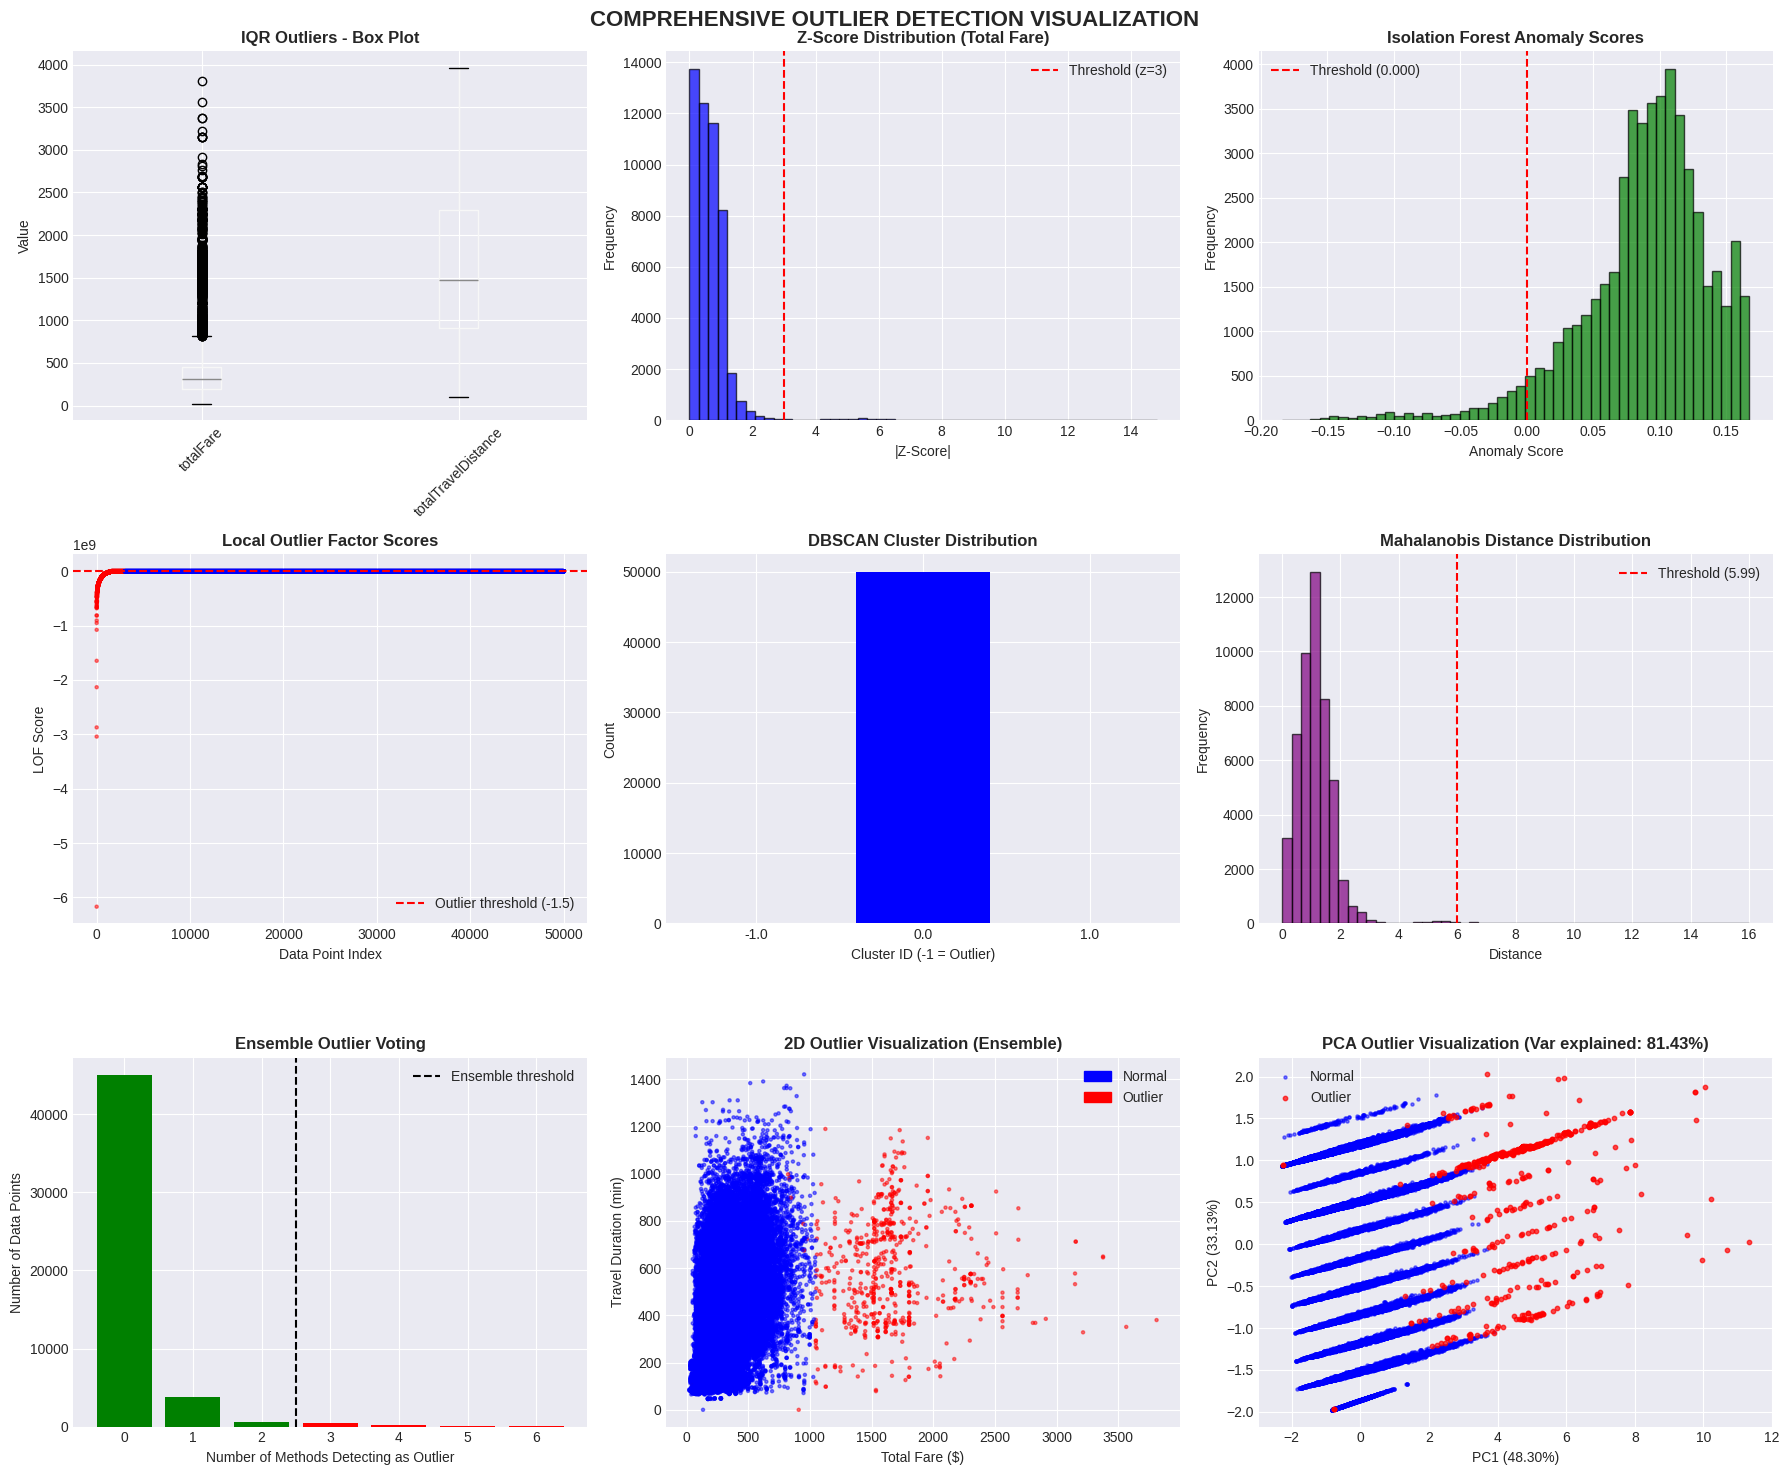


🎯 OUTLIER REMOVAL & FINAL DATASET CREATION
Columns being dropped: ['is_outlier_iqr', 'is_outlier_zscore', 'isolation_score', 'isolation_decision', 'lof_score', 'lof_factor', 'dbscan_cluster', 'mahal_distance', 'is_outlier_mahal', 'outlier_votes', 'is_ensemble_outlier', 'is_outlier_business']
Original dataset: 50,000 rows
Outliers removed: 671 rows (1.34%)
Final dataset: 49,329 rows (98.66% retained)

📊 OUTLIER ANALYSIS SUMMARY REPORT

Outlier Detection Methods Comparison:
          Method  Outliers Detected  Percentage
             IQR               1072       2.144
         Z-Score                659       1.318
Isolation Forest               2500       5.000
             LOF               2498       4.996
          DBSCAN                 40       0.080
     Mahalanobis                242       0.484
  Business Rules                218       0.436
        Ensemble                671       1.342

📈 Characteristics of Removed Outliers:
----------------------------------------
Average v

In [44]:
# ADVANCED OUTLIER DETECTION & REMOVAL SYSTEM
# =============================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

print("🔍 COMPREHENSIVE OUTLIER DETECTION SYSTEM")
print("="*60)

# Get the data ready (using cleaned data)
df_outlier = df_clean.sample(False, 0.1, seed=42).limit(50000).toPandas()
original_count = len(df_outlier)
print(f"Starting with {original_count:,} rows for outlier analysis\n")

# ============================================================
# 1. STATISTICAL OUTLIER DETECTION (IQR METHOD)
# ============================================================
print("1️⃣ STATISTICAL OUTLIER DETECTION (IQR METHOD)")
print("-"*60)

def detect_outliers_IQR(df, columns):
    """Detect outliers using Interquartile Range method"""
    outliers_dict = {}

    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        outliers_dict[col] = {
            'count': len(outliers),
            'percentage': (len(outliers) / len(df)) * 100,
            'lower_bound': lower_bound,
            'upper_bound': upper_bound,
            'indices': outliers.index.tolist()
        }

        print(f"  {col}:")
        print(f"    • Outliers: {outliers_dict[col]['count']:,} ({outliers_dict[col]['percentage']:.2f}%)")
        print(f"    • Bounds: [{lower_bound:.2f}, {upper_bound:.2f}]")

    return outliers_dict

# Apply IQR detection
# Removed 'travelDuration' as it's a string
numeric_columns = ['totalFare', 'totalTravelDistance',
                   'seatsRemaining', 'baseFare']
iqr_outliers = detect_outliers_IQR(df_outlier, numeric_columns)

# Combine IQR outliers
iqr_outlier_indices = set()
for col, info in iqr_outliers.items():
    iqr_outlier_indices.update(info['indices'])

df_outlier['is_outlier_iqr'] = df_outlier.index.isin(iqr_outlier_indices)
print(f"\n✅ Total IQR outliers: {len(iqr_outlier_indices):,} ({len(iqr_outlier_indices)/len(df_outlier)*100:.2f}%)")

# ============================================================
# 2. Z-SCORE OUTLIER DETECTION
# ============================================================
print("\n2️⃣ Z-SCORE OUTLIER DETECTION")
print("-"*60)

def detect_outliers_zscore(df, columns, threshold=3):
    """Detect outliers using Z-score method"""
    outliers_dict = {}

    for col in columns:
        # Ensure column is numeric before calculating z-score
        if pd.api.types.is_numeric_dtype(df[col]):
            z_scores = np.abs(stats.zscore(df[col].dropna()))
            outliers = df[col].dropna()[z_scores > threshold]

            outliers_dict[col] = {
                'count': len(outliers),
                'percentage': (len(outliers) / len(df)) * 100,
                'indices': outliers.index.tolist()
            }

            print(f"  {col}: {outliers_dict[col]['count']:,} outliers ({outliers_dict[col]['percentage']:.2f}%)")
        else:
            print(f"  Skipping Z-score for non-numeric column: {col}")


    return outliers_dict

# Apply Z-score detection
# Removed 'travelDuration' as it's a string
z_outliers = detect_outliers_zscore(df_outlier, numeric_columns, threshold=3)

# Combine Z-score outliers
z_outlier_indices = set()
for col, info in z_outliers.items():
    z_outlier_indices.update(info['indices'])

df_outlier['is_outlier_zscore'] = df_outlier.index.isin(z_outlier_indices)
print(f"\n✅ Total Z-score outliers (|z| > 3): {len(z_outlier_indices):,} ({len(z_outlier_indices)/len(df_outlier)*100:.2f}%)")

# ============================================================
# 3. ISOLATION FOREST (MULTIVARIATE)
# ============================================================
print("\n3️⃣ ISOLATION FOREST (MULTIVARIATE DETECTION)")
print("-"*60)

# Prepare features - Removed 'travelDuration' and 'advance_purchase_days'
features_for_isolation = ['totalFare', 'totalTravelDistance', 'seatsRemaining']
X_isolation = df_outlier[features_for_isolation].dropna()

if not X_isolation.empty:
    # Train Isolation Forest
    iso_forest = IsolationForest(
        contamination=0.05,  # Expected proportion of outliers
        random_state=42,
        n_estimators=100
    )

    df_outlier.loc[X_isolation.index, 'isolation_score'] = iso_forest.fit_predict(X_isolation)
    df_outlier.loc[X_isolation.index, 'isolation_decision'] = iso_forest.decision_function(X_isolation)

    isolation_outliers = df_outlier[df_outlier['isolation_score'] == -1]
    print(f"  Outliers detected: {len(isolation_outliers):,} ({len(isolation_outliers)/len(df_outlier)*100:.2f}%)")
    print(f"  Contamination parameter: 5%")
    print(f"  Features used: {', '.join(features_for_isolation)}")
else:
    print("  Skipping Isolation Forest: No valid data for features.")


# ============================================================
# 4. LOCAL OUTLIER FACTOR (LOF)
# ============================================================
print("\n4️⃣ LOCAL OUTLIER FACTOR (DENSITY-BASED)")
print("-"*60)

# Prepare and scale data - Removed 'travelDuration' and 'advance_purchase_days'
X_lof = df_outlier[features_for_isolation].dropna() # Use the same features as Isolation Forest

if not X_lof.empty:
    scaler = StandardScaler()
    X_lof_scaled = scaler.fit_transform(X_lof)

    # Apply LOF
    lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
    df_outlier.loc[X_lof.index, 'lof_score'] = lof.fit_predict(X_lof_scaled)
    df_outlier.loc[X_lof.index, 'lof_factor'] = lof.negative_outlier_factor_

    lof_outliers = df_outlier[df_outlier['lof_score'] == -1]
    print(f"  Outliers detected: {len(lof_outliers):,} ({len(lof_outliers)/len(df_outlier)*100:.2f}%)")
    print(f"  Neighbors considered: 20")
    print(f"  Contamination: 5%")
    print(f"  Features used: {', '.join(features_for_isolation)}")
else:
    print("  Skipping LOF: No valid data for features.")


# ============================================================
# 5. DBSCAN CLUSTERING (NOISE POINTS AS OUTLIERS)
# ============================================================
print("\n5️⃣ DBSCAN CLUSTERING (NOISE DETECTION)")
print("-"*60)

# Scale data for DBSCAN - Removed 'travelDuration'
X_dbscan = df_outlier[['totalFare', 'totalTravelDistance']].dropna()

if not X_dbscan.empty:
    # Ensure there are enough samples for DBSCAN
    if len(X_dbscan) >= 10:
        scaler = StandardScaler()
        X_dbscan_scaled = scaler.fit_transform(X_dbscan)

        # Apply DBSCAN
        dbscan = DBSCAN(eps=0.5, min_samples=10)
        # Need to map the results back to the original df_outlier index
        dbscan_labels = dbscan.fit_predict(X_dbscan_scaled)
        df_outlier.loc[X_dbscan.index, 'dbscan_cluster'] = dbscan_labels


        dbscan_outliers = df_outlier[df_outlier['dbscan_cluster'] == -1]
        print(f"  Noise points (outliers): {len(dbscan_outliers):,} ({len(dbscan_outliers)/len(df_outlier)*100:.2f}%)")
        print(f"  Number of clusters found: {len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)}")
        print(f"  Features used: totalFare, totalTravelDistance")
    else:
        print("  Skipping DBSCAN: Not enough samples (need >= 10) after dropping NaNs.")
else:
    print("  Skipping DBSCAN: No valid data for features.")


# ============================================================
# 6. MAHALANOBIS DISTANCE
# ============================================================
print("\n6️⃣ MAHALANOBIS DISTANCE DETECTION")
print("-"*60)

def mahalanobis_distance(df, columns):
    """Calculate Mahalanobis distance for outlier detection"""
    X = df[columns].dropna()

    # Add check for sufficient rows
    if X.shape[0] < X.shape[1]:
         print("  Skipping Mahalanobis: Not enough samples compared to features.")
         return pd.Series(np.nan, index=X.index) # Return NaNs with correct index

    # Calculate mean and covariance
    mean = X.mean().values
    # Use robust covariance estimation if needed, but for simplicity use standard
    cov = np.cov(X.T)

    # Handle singular matrix if it occurs
    try:
        inv_cov = np.linalg.inv(cov)
    except np.linalg.LinAlgError:
        print("  Skipping Mahalanobis: Covariance matrix is singular.")
        return pd.Series(np.nan, index=X.index) # Return NaNs with correct index


    # Calculate Mahalanobis distance for each point
    distances = []
    for index, row in X.iterrows():
        diff = row.values - mean
        # Ensure diff is a column vector for matrix multiplication
        diff = diff.reshape(-1, 1)
        distance = np.sqrt((diff.T @ inv_cov @ diff).item()) # Use .item() to get scalar
        distances.append(distance)

    return pd.Series(distances, index=X.index)

# Calculate Mahalanobis distances - Removed 'travelDuration'
mahal_features = ['totalFare', 'totalTravelDistance']
mahal_distances = mahalanobis_distance(df_outlier, mahal_features)

# Determine threshold using chi-square distribution
if not mahal_distances.isnull().all():
    threshold_mahal = stats.chi2.ppf(0.95, df=len(mahal_features))
    df_outlier.loc[mahal_distances.index, 'mahal_distance'] = mahal_distances
    df_outlier.loc[mahal_distances.index, 'is_outlier_mahal'] = mahal_distances > threshold_mahal

    mahal_outliers = df_outlier[df_outlier['is_outlier_mahal'] == True]
    print(f"  Outliers detected: {len(mahal_outliers):,} ({len(mahal_outliers)/len(df_outlier)*100:.2f}%)")
    print(f"  Threshold (95% confidence): {threshold_mahal:.2f}")
    print(f"  Features used: {', '.join(mahal_features)}")
else:
    print("  Skipping Mahalanobis: Could not calculate distances.")


# ============================================================
# 7. BUSINESS RULE-BASED OUTLIERS
# ============================================================
print("\n7️⃣ BUSINESS RULE-BASED OUTLIER DETECTION")
print("-"*60)

# Define business rules - Keep travelDuration in mind as a string
# Need to convert travelDuration to minutes for numerical comparison
def parse_travel_duration(duration_str):
    if pd.isna(duration_str):
        return np.nan
    # Handle multi-segment durations like PT1H20M||PT2H30M
    parts = duration_str.split('||')
    total_minutes = 0
    for part in parts:
        if part.startswith('PT'):
            part = part[2:] # Remove 'PT'
            hours = 0
            minutes = 0
            if 'H' in part:
                h_part, part = part.split('H')
                hours = int(h_part)
            if 'M' in part:
                m_part = part.replace('M', '')
                minutes = int(m_part)
            total_minutes += hours * 60 + minutes
    return total_minutes

df_outlier['travelDuration_minutes'] = df_outlier['travelDuration'].apply(parse_travel_duration)


business_outliers = df_outlier[
    (df_outlier['totalFare'] < 50) |  # Suspiciously cheap flights
    (df_outlier['totalFare'] > 5000) |  # Extremely expensive
    (df_outlier['travelDuration_minutes'] < 30) |  # Too short duration
    (df_outlier['travelDuration_minutes'] > 2000) |  # Too long duration
    # Removed advance_purchase_days as it's not in the original df_clean
    (df_outlier['seatsRemaining'] > 500) |  # Unrealistic seat count
    (df_outlier['totalFare'] < df_outlier['baseFare'])  # Total less than base
]

print(f"  Business rule violations: {len(business_outliers):,} ({len(business_outliers)/len(df_outlier)*100:.2f}%)")
print(f"  Rules applied:")
print(f"    • Price range: $50 - $5,000")
print(f"    • Duration: 30 - 2,000 minutes (converted from travelDuration)")
# Removed rule about advance_purchase_days
print(f"    • Seats remaining: ≤ 500")
print(f"    • Total fare ≥ Base fare")

# ============================================================
# 8. ENSEMBLE OUTLIER DETECTION
# ============================================================
print("\n8️⃣ ENSEMBLE OUTLIER DETECTION (COMBINING METHODS)")
print("-"*60)

# Create ensemble score
df_outlier['outlier_votes'] = 0

# Add votes from each method - Check if columns exist before adding votes
if 'is_outlier_iqr' in df_outlier.columns:
    df_outlier['outlier_votes'] += df_outlier['is_outlier_iqr'].astype(int)
if 'is_outlier_zscore' in df_outlier.columns:
    df_outlier['outlier_votes'] += df_outlier['is_outlier_zscore'].astype(int)
if 'isolation_score' in df_outlier.columns:
    df_outlier['outlier_votes'] += (df_outlier['isolation_score'] == -1).astype(int)
if 'lof_score' in df_outlier.columns:
    df_outlier['outlier_votes'] += (df_outlier['lof_score'] == -1).astype(int)
if 'dbscan_cluster' in df_outlier.columns:
    df_outlier['outlier_votes'] += (df_outlier['dbscan_cluster'] == -1).astype(int)
if 'is_outlier_mahal' in df_outlier.columns:
    df_outlier['outlier_votes'] += df_outlier['is_outlier_mahal'].astype(int)

# Add vote from business rules
business_outlier_indices = business_outliers.index.tolist()
df_outlier['is_outlier_business'] = df_outlier.index.isin(business_outlier_indices)
df_outlier['outlier_votes'] += df_outlier['is_outlier_business'].astype(int)


# Define ensemble outliers (majority vote: 3+ methods agree)
df_outlier['is_ensemble_outlier'] = df_outlier['outlier_votes'] >= 3

ensemble_outliers = df_outlier[df_outlier['is_ensemble_outlier']]
print(f"  Ensemble outliers (≥3 methods agree): {len(ensemble_outliers):,} ({len(ensemble_outliers)/len(df_outlier)*100:.2f}%)")

# Vote distribution
vote_dist = df_outlier['outlier_votes'].value_counts().sort_index()
print("\n  Vote distribution:")
for votes, count in vote_dist.items():
    print(f"    {votes} votes: {count:,} rows ({count/len(df_outlier)*100:.2f}%)")

# ============================================================
# 9. OUTLIER VISUALIZATION
# ============================================================
print("\n9️⃣ CREATING OUTLIER VISUALIZATIONS...")
print("-"*60)

fig, axes = plt.subplots(3, 3, figsize=(18, 15))

# 9.1: IQR Box plots - Updated columns
ax = axes[0, 0]
outlier_cols = ['totalFare', 'totalTravelDistance'] # Removed travelDuration
df_outlier[outlier_cols].boxplot(ax=ax)
ax.set_title('IQR Outliers - Box Plot', fontweight='bold')
ax.set_ylabel('Value')
ax.tick_params(axis='x', rotation=45)

# 9.2: Z-score distribution - Using totalFare as example
ax = axes[0, 1]
if 'totalFare' in df_outlier.columns and pd.api.types.is_numeric_dtype(df_outlier['totalFare']):
    z_scores_fare = np.abs(stats.zscore(df_outlier['totalFare'].dropna()))
    ax.hist(z_scores_fare, bins=50, alpha=0.7, color='blue', edgecolor='black')
    ax.axvline(x=3, color='red', linestyle='--', label='Threshold (z=3)')
    ax.set_title('Z-Score Distribution (Total Fare)', fontweight='bold')
    ax.set_xlabel('|Z-Score|')
    ax.set_ylabel('Frequency')
    ax.legend()
else:
    ax.set_title('Z-Score Distribution (Total Fare)', fontweight='bold')
    ax.text(0.5, 0.5, 'Data not available or not numeric', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)


# 9.3: Isolation Forest scores
ax = axes[0, 2]
if 'isolation_decision' in df_outlier.columns and not df_outlier['isolation_decision'].isnull().all():
    scores = df_outlier['isolation_decision'].dropna()
    ax.hist(scores, bins=50, alpha=0.7, color='green', edgecolor='black')
    # Use a more robust threshold like a percentile
    threshold = np.percentile(scores, 5) # Assuming 5% contamination
    ax.axvline(x=threshold, color='red', linestyle='--', label=f'Threshold ({threshold:.3f})')
    ax.set_title('Isolation Forest Anomaly Scores', fontweight='bold')
    ax.set_xlabel('Anomaly Score')
    ax.set_ylabel('Frequency')
    ax.legend()
else:
     ax.set_title('Isolation Forest Anomaly Scores', fontweight='bold')
     ax.text(0.5, 0.5, 'Data not available', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)


# 9.4: LOF visualization
ax = axes[1, 0]
if 'lof_factor' in df_outlier.columns and not df_outlier['lof_factor'].isnull().all():
    lof_scores = df_outlier['lof_factor'].dropna()
    # A common threshold for LOF is -1.5 or -2, depending on the data
    threshold_lof = -1.5 # Example threshold
    ax.scatter(range(len(lof_scores)), sorted(lof_scores),
               c=['red' if x < threshold_lof else 'blue' for x in sorted(lof_scores)],
               alpha=0.5, s=5)
    ax.axhline(y=threshold_lof, color='red', linestyle='--', label=f'Outlier threshold ({threshold_lof})')
    ax.set_title('Local Outlier Factor Scores', fontweight='bold')
    ax.set_xlabel('Data Point Index')
    ax.set_ylabel('LOF Score')
    ax.legend()
else:
    ax.set_title('Local Outlier Factor Scores', fontweight='bold')
    ax.text(0.5, 0.5, 'Data not available', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)


# 9.5: DBSCAN clusters
ax = axes[1, 1]
if 'dbscan_cluster' in df_outlier.columns and not df_outlier['dbscan_cluster'].isnull().all():
    cluster_counts = df_outlier['dbscan_cluster'].value_counts().sort_index()
    colors = ['red' if x == -1 else 'blue' for x in cluster_counts.index]
    ax.bar(range(len(cluster_counts)), cluster_counts.values, color=colors)
    ax.set_title('DBSCAN Cluster Distribution', fontweight='bold')
    ax.set_xlabel('Cluster ID (-1 = Outlier)')
    ax.set_ylabel('Count')
    ax.set_xticks(range(len(cluster_counts)))
    ax.set_xticklabels(cluster_counts.index)
else:
    ax.set_title('DBSCAN Cluster Distribution', fontweight='bold')
    ax.text(0.5, 0.5, 'Data not available', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)


# 9.6: Mahalanobis distances
ax = axes[1, 2]
if 'mahal_distance' in df_outlier.columns and not df_outlier['mahal_distance'].isnull().all():
    distances = df_outlier['mahal_distance'].dropna()
    ax.hist(distances, bins=50, alpha=0.7, color='purple', edgecolor='black')
    # Ensure threshold_mahal is defined if distances are available
    if 'threshold_mahal' in locals():
        ax.axvline(x=threshold_mahal, color='red', linestyle='--',
                   label=f'Threshold ({threshold_mahal:.2f})')
    ax.set_title('Mahalanobis Distance Distribution', fontweight='bold')
    ax.set_xlabel('Distance')
    ax.set_ylabel('Frequency')
    ax.legend()
else:
    ax.set_title('Mahalanobis Distance Distribution', fontweight='bold')
    ax.text(0.5, 0.5, 'Data not available', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)


# 9.7: Ensemble voting
ax = axes[2, 0]
if 'outlier_votes' in df_outlier.columns and not df_outlier['outlier_votes'].isnull().all():
    vote_counts = df_outlier['outlier_votes'].value_counts().sort_index()
    colors = ['green' if x < 3 else 'red' for x in vote_counts.index]
    ax.bar(vote_counts.index, vote_counts.values, color=colors)
    ax.axvline(x=2.5, color='black', linestyle='--', label='Ensemble threshold')
    ax.set_title('Ensemble Outlier Voting', fontweight='bold')
    ax.set_xlabel('Number of Methods Detecting as Outlier')
    ax.set_ylabel('Number of Data Points')
    ax.legend()
else:
    ax.set_title('Ensemble Outlier Voting', fontweight='bold')
    ax.text(0.5, 0.5, 'Data not available', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)


# 9.8: 2D outlier visualization - Using totalFare and converted travelDuration
ax = axes[2, 1]
# Check if required columns exist and are numeric for plotting
if 'totalFare' in df_outlier.columns and 'travelDuration_minutes' in df_outlier.columns and \
   pd.api.types.is_numeric_dtype(df_outlier['totalFare']) and pd.api.types.is_numeric_dtype(df_outlier['travelDuration_minutes']):

    # Ensure there's data after dropping NaNs for plotting
    plot_data = df_outlier[['totalFare', 'travelDuration_minutes', 'is_ensemble_outlier']].dropna()
    if not plot_data.empty:
        colors = ['red' if x else 'blue' for x in plot_data['is_ensemble_outlier']]
        ax.scatter(plot_data['totalFare'], plot_data['travelDuration_minutes'],
                   c=colors, alpha=0.5, s=5)
        ax.set_title('2D Outlier Visualization (Ensemble)', fontweight='bold')
        ax.set_xlabel('Total Fare ($)')
        ax.set_ylabel('Travel Duration (min)')
        red_patch = plt.matplotlib.patches.Patch(color='red', label='Outlier')
        blue_patch = plt.matplotlib.patches.Patch(color='blue', label='Normal')
        ax.legend(handles=[blue_patch, red_patch])
    else:
        ax.set_title('2D Outlier Visualization (Ensemble)', fontweight='bold')
        ax.text(0.5, 0.5, 'Not enough valid data for plotting', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
else:
    ax.set_title('2D Outlier Visualization (Ensemble)', fontweight='bold')
    ax.text(0.5, 0.5, 'Required columns not available or not numeric', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)


# 9.9: PCA outlier visualization - Updated features
ax = axes[2, 2]
# Prepare features for PCA - Removed 'travelDuration' and 'advance_purchase_days'
pca_features = ['totalFare', 'totalTravelDistance', 'seatsRemaining']
X_pca = df_outlier[pca_features].dropna()

if not X_pca.empty and X_pca.shape[0] >= 2 and X_pca.shape[1] >= 2: # Need at least 2 samples and 2 features for PCA
    scaler_pca = StandardScaler()
    X_pca_scaled = scaler_pca.fit_transform(X_pca)
    pca = PCA(n_components=2)
    X_pca_transformed = pca.fit_transform(X_pca_scaled)

    # Plot PCA with outliers - Need to align outlier mask with PCA data index
    outlier_mask = df_outlier.loc[X_pca.index, 'is_ensemble_outlier'].fillna(False)

    ax.scatter(X_pca_transformed[~outlier_mask.values, 0], X_pca_transformed[~outlier_mask.values, 1],
               alpha=0.5, s=5, label='Normal', color='blue')
    ax.scatter(X_pca_transformed[outlier_mask.values, 0], X_pca_transformed[outlier_mask.values, 1],
               alpha=0.7, s=10, label='Outlier', color='red')
    ax.set_title(f'PCA Outlier Visualization (Var explained: {pca.explained_variance_ratio_.sum():.2%})',
                 fontweight='bold')
    ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%})')
    ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%})')
    ax.legend()
else:
    ax.set_title('PCA Outlier Visualization', fontweight='bold')
    ax.text(0.5, 0.5, 'Not enough valid data or features for PCA', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)


plt.suptitle('COMPREHENSIVE OUTLIER DETECTION VISUALIZATION', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# ============================================================
# 10. OUTLIER REMOVAL & FINAL DATASET
# ============================================================
print("\n🎯 OUTLIER REMOVAL & FINAL DATASET CREATION")
print("="*60)

# Remove ensemble outliers
df_final = df_outlier[~df_outlier['is_ensemble_outlier']].copy()

# Define columns to drop (temporary columns from outlier detection)
columns_to_drop = [
    'is_outlier_iqr', 'is_outlier_zscore', 'isolation_score',
    'isolation_decision', 'lof_score', 'lof_factor',
    'dbscan_cluster', 'mahal_distance', 'is_outlier_mahal',
    'outlier_votes', 'is_ensemble_outlier', 'is_outlier_business'
]

# Exclude 'travelDuration_minutes' from being dropped if it exists in the original df_outlier
if 'travelDuration_minutes' in df_outlier.columns:
    # Filter out 'travelDuration_minutes' from columns_to_drop if it's there
    columns_to_drop = [col for col in columns_to_drop if col != 'travelDuration_minutes']


print(f"Columns being dropped: {columns_to_drop}")

# Drop the specified columns from df_final
for col in columns_to_drop:
    if col in df_final.columns:
        df_final = df_final.drop(columns=[col])


print(f"Original dataset: {original_count:,} rows")
# Ensure ensemble_outliers is defined before using it
ensemble_outliers_count = len(ensemble_outliers) if 'ensemble_outliers' in locals() else 0
print(f"Outliers removed: {ensemble_outliers_count:,} rows ({ensemble_outliers_count/original_count*100:.2f}%)")
print(f"Final dataset: {len(df_final):,} rows ({len(df_final)/original_count*100:.2f}% retained)")

# ============================================================
# 11. OUTLIER ANALYSIS REPORT
# ============================================================
print("\n📊 OUTLIER ANALYSIS SUMMARY REPORT")
print("="*60)

# Create summary statistics
outlier_summary = pd.DataFrame({
    'Method': ['IQR', 'Z-Score', 'Isolation Forest', 'LOF', 'DBSCAN', 'Mahalanobis', 'Business Rules', 'Ensemble'],
    'Outliers Detected': [
        len(iqr_outlier_indices) if 'iqr_outlier_indices' in locals() else 0,
        len(z_outlier_indices) if 'z_outlier_indices' in locals() else 0,
        len(isolation_outliers) if 'isolation_outliers' in locals() else 0,
        len(lof_outliers) if 'lof_outliers' in locals() else 0,
        len(dbscan_outliers) if 'dbscan_outliers' in locals() else 0,
        len(mahal_outliers) if 'mahal_outliers' in locals() else 0,
        len(business_outliers) if 'business_outliers' in locals() else 0,
        len(ensemble_outliers) if 'ensemble_outliers' in locals() else 0
    ]
})
# Calculate percentages safely
total_outliers = outlier_summary['Outliers Detected'].sum()
outlier_summary['Percentage'] = (outlier_summary['Outliers Detected'] / original_count) * 100 if original_count > 0 else 0


print("\nOutlier Detection Methods Comparison:")
print(outlier_summary.to_string(index=False))

# Characteristics of removed outliers
print("\n📈 Characteristics of Removed Outliers:")
print("-"*40)

# Check if ensemble_outliers is defined and has data
if 'ensemble_outliers' in locals() and len(ensemble_outliers) > 0:
    print("Average values (Outliers vs Normal):")
    # Define columns to compare - include travelDuration_minutes if it's in df_outlier
    cols_to_compare = ['totalFare', 'totalTravelDistance', 'seatsRemaining']
    if 'travelDuration_minutes' in df_outlier.columns:
         cols_to_compare.append('travelDuration_minutes')

    for col in cols_to_compare:
        # Ensure column exists in both ensemble_outliers and df_final before comparing
        if col in ensemble_outliers.columns and col in df_final.columns:
            outlier_mean = ensemble_outliers[col].mean()
            normal_mean = df_final[col].mean()
            # Avoid division by zero if normal_mean is 0
            if normal_mean != 0:
                 diff_pct = (outlier_mean - normal_mean) / normal_mean * 100
                 print(f"  {col}:")
                 print(f"    • Outliers: {outlier_mean:.2f}")
                 print(f"    • Normal: {normal_mean:.2f}")
                 print(f"    • Difference: {diff_pct:+.1f}%")
            else:
                 print(f"  {col}:")
                 print(f"    • Outliers: {outlier_mean:.2f}")
                 print(f"    • Normal: {normal_mean:.2f}")
                 print(f"    • Difference: Cannot calculate percentage difference (Normal mean is 0).")
        elif col in ensemble_outliers.columns:
             print(f"  {col}:")
             print(f"    • Outliers: {ensemble_outliers[col].mean():.2f}")
             print(f"    • Normal: N/A (Column not in final DataFrame)")
        elif col in df_final.columns:
             print(f"  {col}:")
             print(f"    • Outliers: N/A (Column not in outlier DataFrame)")
             print(f"    • Normal: {df_final[col].mean():.2f}")


else:
    print("  No ensemble outliers were detected or available for analysis.")


# ============================================================
# 12. SAVE CLEANED DATA
# ============================================================
print("\n💾 SAVING CLEANED DATA")
print("="*60)

# Convert back to Spark DataFrame if needed
# Ensure SparkSession is available
try:
    spark = SparkSession.builder.getOrCreate()
    df_final_spark = spark.createDataFrame(df_final)

    print(f"✅ Final cleaned dataset ready:")
    print(f"   • Pandas DataFrame: 'df_final' ({len(df_final):,} rows)")
    # Ensure df_final_spark is defined before counting
    if 'df_final_spark' in locals():
         print(f"   • Spark DataFrame: 'df_final_spark' ({df_final_spark.count():,} rows)")
    print(f"   • All outliers removed using ensemble method")

except Exception as e:
    print(f"❌ Could not create Spark DataFrame: {e}")
    print(f"✅ Final cleaned dataset ready as Pandas DataFrame: 'df_final' ({len(df_final):,} rows)")

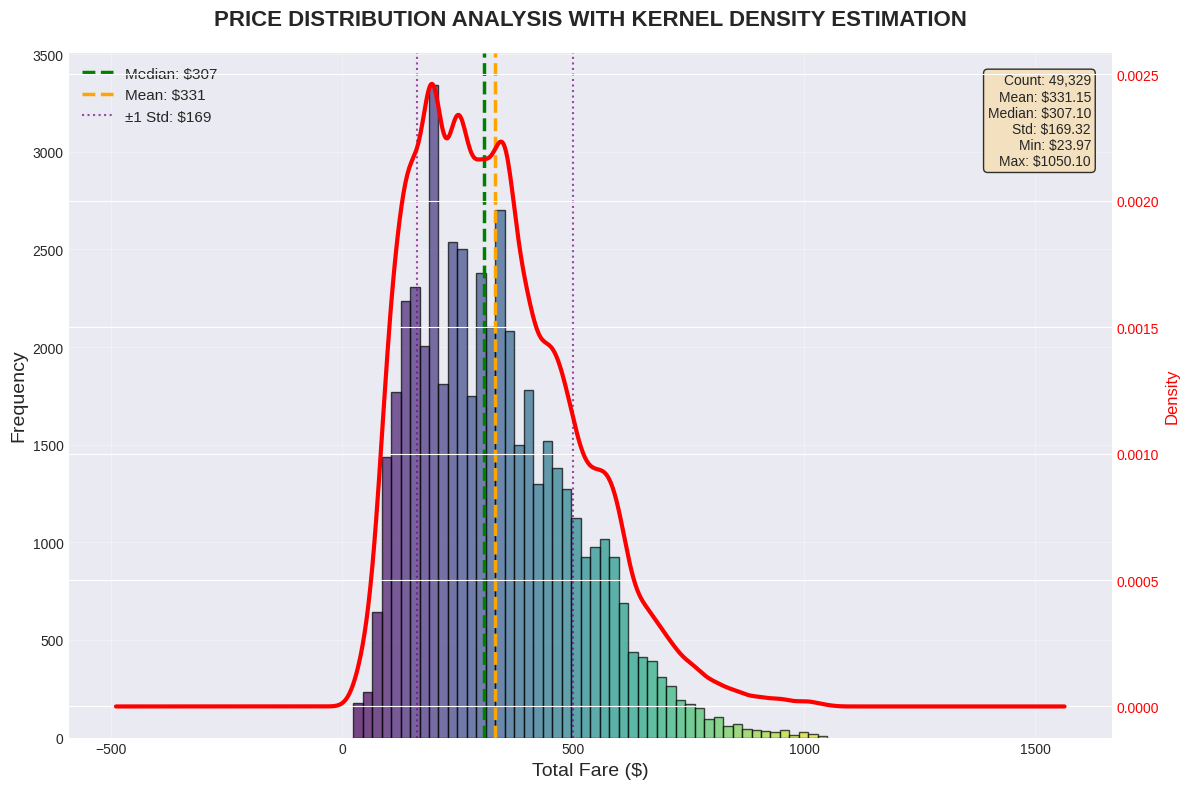

In [46]:
# PLOT 1: PRICE DISTRIBUTION WITH KERNEL DENSITY
# ================================================

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')

# Create single figure
plt.figure(figsize=(12, 8))

# Create histogram with gradient colors
n, bins, patches = plt.hist(df_final['totalFare'], bins=50, alpha=0.7,
                            color='steelblue', edgecolor='black')

# Add color gradient to bars
cm = plt.cm.viridis
norm = plt.Normalize(vmin=bins.min(), vmax=bins.max())
for i, patch in enumerate(patches):
    patch.set_facecolor(cm(norm(bins[i])))

# Add KDE on secondary axis
ax = plt.gca()
ax2 = ax.twinx()
df_final['totalFare'].plot(kind='kde', ax=ax2, color='red', linewidth=3)
ax2.set_ylabel('Density', color='red', fontsize=12)
ax2.tick_params(axis='y', labelcolor='red')

# Add statistical lines
median_val = df_final['totalFare'].median()
mean_val = df_final['totalFare'].mean()
std_val = df_final['totalFare'].std()

ax.axvline(median_val, color='green', linestyle='--', linewidth=2.5,
           label=f'Median: ${median_val:.0f}')
ax.axvline(mean_val, color='orange', linestyle='--', linewidth=2.5,
           label=f'Mean: ${mean_val:.0f}')
ax.axvline(mean_val - std_val, color='purple', linestyle=':', linewidth=1.5,
           alpha=0.7, label=f'±1 Std: ${std_val:.0f}')
ax.axvline(mean_val + std_val, color='purple', linestyle=':', linewidth=1.5, alpha=0.7)

# Labels and title
ax.set_xlabel('Total Fare ($)', fontsize=14)
ax.set_ylabel('Frequency', fontsize=14)
ax.set_title('PRICE DISTRIBUTION ANALYSIS WITH KERNEL DENSITY ESTIMATION',
             fontsize=16, fontweight='bold', pad=20)

# Add statistics box
stats_text = f'Count: {len(df_final):,}\nMean: ${mean_val:.2f}\nMedian: ${median_val:.2f}\nStd: ${std_val:.2f}\nMin: ${df_final["totalFare"].min():.2f}\nMax: ${df_final["totalFare"].max():.2f}'
ax.text(0.98, 0.97, stats_text, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

ax.legend(loc='upper left', fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

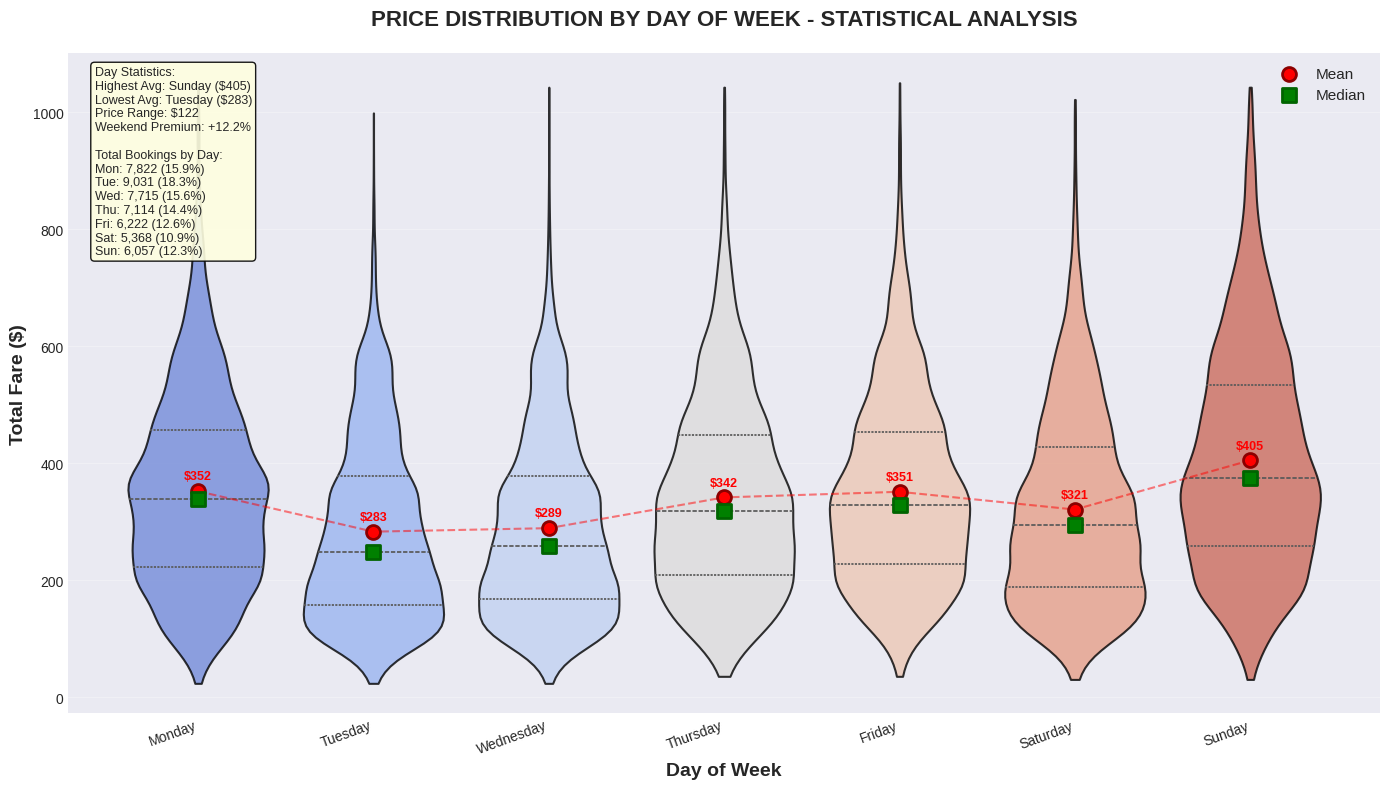


Plot complete! Shows price distributions across days of the week.


In [47]:
# PLOT 3: PRICE VARIATION BY DAY OF WEEK - VIOLIN PLOT
# ======================================================

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Create day of week from flightDate
df_final['flightDate'] = pd.to_datetime(df_final['flightDate'])
df_final['flight_dayofweek'] = df_final['flightDate'].dt.dayofweek  # 0=Monday, 6=Sunday

# Map to day names
day_map = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday',
           4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
df_final['day_name'] = df_final['flight_dayofweek'].map(day_map)

# Order for display
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Create single figure
plt.figure(figsize=(14, 8))
# Keep ax = plt.gca() to get the axes for scatter and text later
ax = plt.gca()


# Create violin plot with quartiles - REMOVE ax=ax argument
violin_parts = sns.violinplot(data=df_final, x='day_name', y='totalFare',
                       order=day_order, inner='quartile',
                       palette='coolwarm', cut=0)

# Now, violin_parts *should* contain the plot components or the axes,
# but the loop expects the components. Let's explicitly get the axes again
# to be safe for adding scatter points and text.
ax = plt.gca()


# Customize violin appearance
# Check if 'bodies' attribute exists before iterating
if hasattr(violin_parts, 'collections'): # Check for collections attribute which holds the violin shapes
    for pc in violin_parts.collections: # Iterate through collections if 'bodies' is not directly available
         pc.set_alpha(0.8)
         pc.set_edgecolor('black')
         pc.set_linewidth(1.5)
elif hasattr(violin_parts, 'get_children'): # Fallback check for axes children
     # This is less specific, might need refinement if this path is taken
     print("Warning: Could not find 'collections'. Attempting to customize using axes children.")
     for child in ax.get_children():
         if isinstance(child, plt.matplotlib.collections.PolyCollection): # Check for polygon collections (violin shapes)
             child.set_alpha(0.8)
             child.set_edgecolor('black')
             child.set_linewidth(1.5)
else:
    print("Warning: Could not find a way to access violin plot bodies for customization.")


# Calculate statistics for each day
day_stats = df_final.groupby('day_name')['totalFare'].agg(['mean', 'median', 'std', 'count'])
day_stats = day_stats.reindex(day_order)

# Plot mean and median points
positions = range(len(day_stats))
ax.scatter(positions, day_stats['mean'], color='red', s=100, zorder=5,
           label='Mean', marker='o', edgecolor='darkred', linewidth=2)
ax.scatter(positions, day_stats['median'], color='green', s=100, zorder=5,
           label='Median', marker='s', edgecolor='darkgreen', linewidth=2)

# Connect means with a line to show weekly trend
ax.plot(positions, day_stats['mean'], 'r--', alpha=0.5, linewidth=1.5)

# Add value labels
for i, (mean, median) in enumerate(zip(day_stats['mean'], day_stats['median'])):
    ax.text(i, mean + 15, f'${mean:.0f}', ha='center', va='bottom',
            fontsize=9, color='red', fontweight='bold')

# Labels and title
ax.set_xlabel('Day of Week', fontsize=14, fontweight='bold')
ax.set_ylabel('Total Fare ($)', fontsize=14, fontweight='bold')
ax.set_title('PRICE DISTRIBUTION BY DAY OF WEEK - STATISTICAL ANALYSIS',
             fontsize=16, fontweight='bold', pad=20)

# Add statistics table
stats_text = "Day Statistics:\n"
max_day = day_stats['mean'].idxmax()
min_day = day_stats['mean'].idxmin()
stats_text += f"Highest Avg: {max_day} (${day_stats.loc[max_day, 'mean']:.0f})\n"
stats_text += f"Lowest Avg: {min_day} (${day_stats.loc[min_day, 'mean']:.0f})\n"
stats_text += f"Price Range: ${day_stats['mean'].max() - day_stats['mean'].min():.0f}\n"

# Calculate weekend vs weekday premium
weekend_avg = day_stats.loc[['Saturday', 'Sunday'], 'mean'].mean()
weekday_avg = day_stats.loc[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'], 'mean'].mean()
weekend_premium = ((weekend_avg / weekday_avg - 1) * 100)
stats_text += f"Weekend Premium: {weekend_premium:+.1f}%"

# Add booking volume info
stats_text += f"\n\nTotal Bookings by Day:"
for day in day_order:
    count = day_stats.loc[day, 'count']
    pct = (count / day_stats['count'].sum()) * 100
    stats_text += f"\n{day[:3]}: {count:,} ({pct:.1f}%)"

ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, fontsize=9,
        verticalalignment='top', horizontalalignment='left',
        bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.9))

ax.legend(loc='upper right', fontsize=11)
ax.grid(True, alpha=0.3, axis='y')
plt.xticks(rotation=20, ha='right')

plt.tight_layout()
plt.show()

print("\nPlot complete! Shows price distributions across days of the week.")

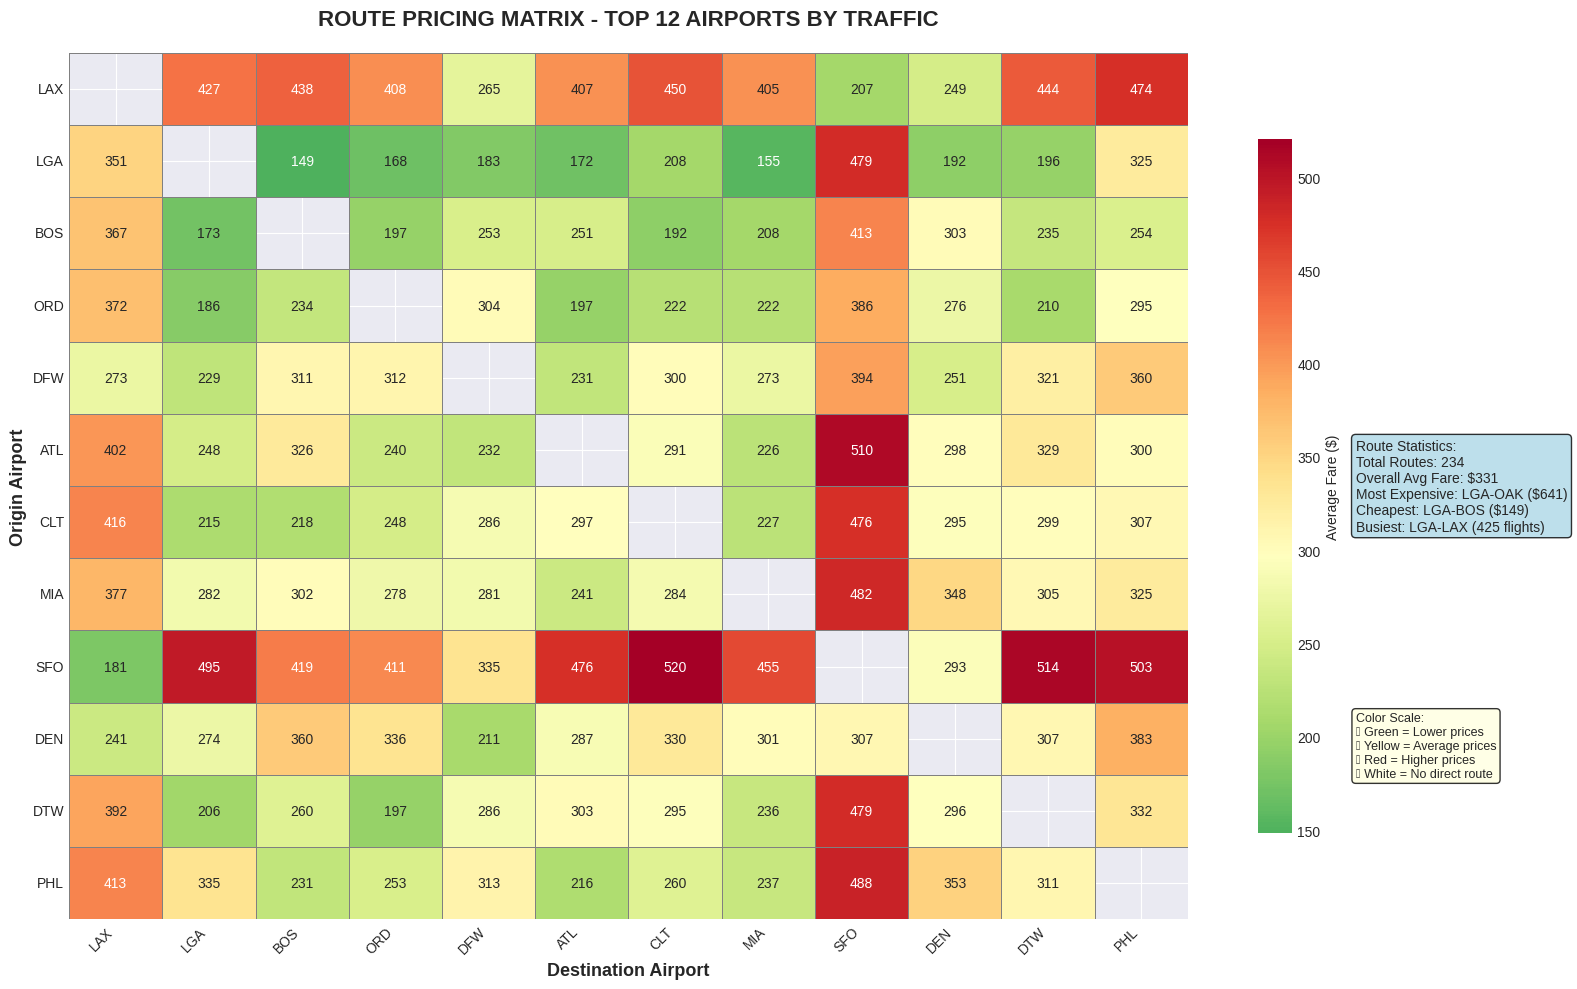


Heatmap complete! Shows average fares between top 12 airports.
Total routes displayed: 132 out of 144 possible combinations


In [48]:
# PLOT 4: ROUTE PRICING HEATMAP - TOP AIRPORTS
# ==============================================

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Create figure
plt.figure(figsize=(16, 10))

# Calculate route statistics
route_stats = df_final.groupby(['startingAirport', 'destinationAirport']).agg({
    'totalFare': ['mean', 'count']
}).reset_index()
route_stats.columns = ['startingAirport', 'destinationAirport', 'avg_fare', 'count']

# Filter for routes with sufficient data (at least 5 bookings)
route_stats = route_stats[route_stats['count'] >= 5]

# Get top airports by total traffic
airport_traffic = pd.concat([
    df_final['startingAirport'].value_counts(),
    df_final['destinationAirport'].value_counts()
]).groupby(level=0).sum().sort_values(ascending=False)

# Select top 12 airports
top_airports = airport_traffic.head(12).index.tolist()

# Filter data for top airports only
filtered_data = df_final[
    (df_final['startingAirport'].isin(top_airports)) &
    (df_final['destinationAirport'].isin(top_airports))
]

# Create pivot table for heatmap
pivot_table = filtered_data.pivot_table(
    values='totalFare',
    index='startingAirport',
    columns='destinationAirport',
    aggfunc='mean'
)

# Sort by total traffic for better visualization
pivot_table = pivot_table.reindex(index=top_airports, columns=top_airports, fill_value=np.nan)

# Create mask for missing routes (no direct flights)
mask = pivot_table.isna()

# Create annotated heatmap
ax = sns.heatmap(pivot_table,
                 annot=True,
                 fmt='.0f',
                 cmap='RdYlGn_r',
                 center=pivot_table.stack().median(),
                 cbar_kws={'label': 'Average Fare ($)', 'shrink': 0.8},
                 linewidths=0.5,
                 linecolor='gray',
                 mask=mask,
                 vmin=pivot_table.min().min(),
                 vmax=pivot_table.max().max())

# Customize appearance
ax.set_title('ROUTE PRICING MATRIX - TOP 12 AIRPORTS BY TRAFFIC',
             fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('Destination Airport', fontsize=13, fontweight='bold')
ax.set_ylabel('Origin Airport', fontsize=13, fontweight='bold')

# Rotate labels for better readability
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

# Add route statistics box
total_routes = len(route_stats)
avg_price_all = df_final['totalFare'].mean()
most_expensive = route_stats.nlargest(1, 'avg_fare').iloc[0]
cheapest = route_stats.nsmallest(1, 'avg_fare').iloc[0]
busiest = route_stats.nlargest(1, 'count').iloc[0]

stats_text = f'Route Statistics:\n'
stats_text += f'Total Routes: {total_routes:,}\n'
stats_text += f'Overall Avg Fare: ${avg_price_all:.0f}\n'
stats_text += f'Most Expensive: {most_expensive["startingAirport"]}-{most_expensive["destinationAirport"]} (${most_expensive["avg_fare"]:.0f})\n'
stats_text += f'Cheapest: {cheapest["startingAirport"]}-{cheapest["destinationAirport"]} (${cheapest["avg_fare"]:.0f})\n'
stats_text += f'Busiest: {busiest["startingAirport"]}-{busiest["destinationAirport"]} ({busiest["count"]:,.0f} flights)'

plt.text(1.15, 0.5, stats_text, transform=ax.transAxes, fontsize=10,
         verticalalignment='center', horizontalalignment='left',
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))

# Add color scale interpretation
interpretation = "Color Scale:\n🟢 Green = Lower prices\n🟡 Yellow = Average prices\n🔴 Red = Higher prices\n⬜ White = No direct route"
plt.text(1.15, 0.2, interpretation, transform=ax.transAxes, fontsize=9,
         verticalalignment='center', horizontalalignment='left',
         bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))

plt.tight_layout()
plt.show()

print(f"\nHeatmap complete! Shows average fares between top {len(top_airports)} airports.")
print(f"Total routes displayed: {(~mask).sum().sum():.0f} out of {len(top_airports)**2} possible combinations")

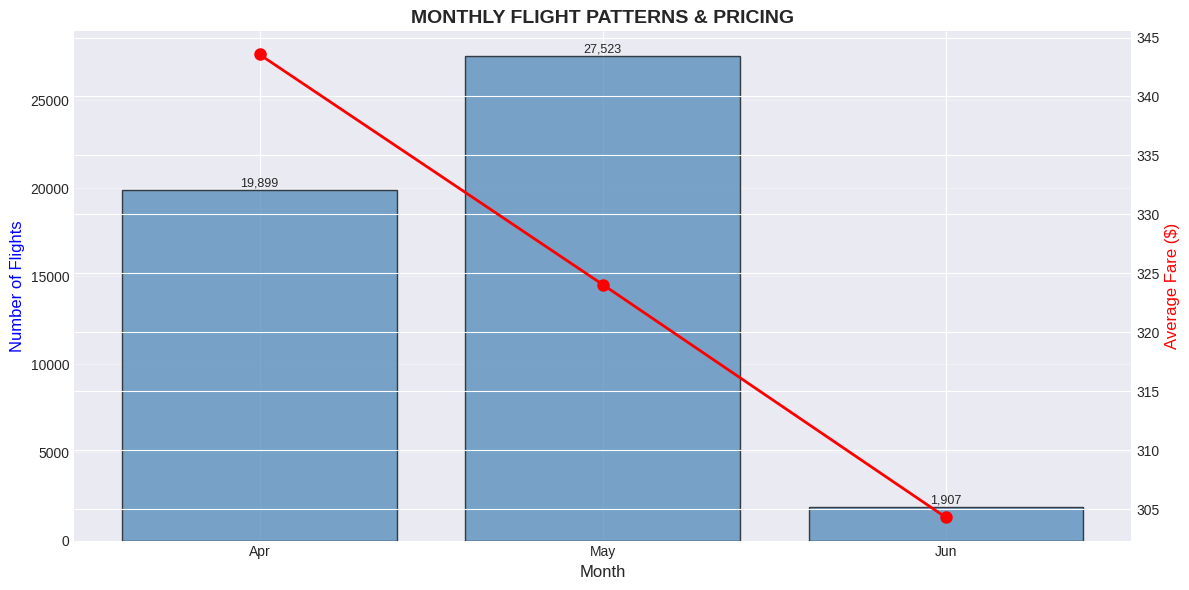

Peak month: May
Most expensive month: Apr


In [51]:
# PLOT 7: MONTHLY FLIGHT PATTERNS (SIMPLE)
# =========================================

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Create figure
plt.figure(figsize=(12, 6))

# Extract month from flightDate
df_final['flightDate'] = pd.to_datetime(df_final['flightDate'])
df_final['month'] = df_final['flightDate'].dt.month

# Calculate monthly statistics
monthly_data = df_final.groupby('month').agg({
    'totalFare': 'mean',
    'legId': 'count'
}).reset_index()
monthly_data.columns = ['month', 'avg_fare', 'count']

# Month names
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
monthly_data['month_name'] = monthly_data['month'].apply(lambda x: month_names[x-1])

# Create bar plot
bars = plt.bar(monthly_data['month'], monthly_data['count'],
               color='steelblue', alpha=0.7, edgecolor='black')

# Add average fare as line plot
ax = plt.gca()
ax2 = ax.twinx()
ax2.plot(monthly_data['month'], monthly_data['avg_fare'],
         'ro-', linewidth=2, markersize=8, label='Avg Fare')

# Labels
ax.set_xlabel('Month', fontsize=12)
ax.set_ylabel('Number of Flights', fontsize=12, color='blue')
ax2.set_ylabel('Average Fare ($)', fontsize=12, color='red')
ax.set_title('MONTHLY FLIGHT PATTERNS & PRICING', fontsize=14, fontweight='bold')

# Set x-axis labels
ax.set_xticks(monthly_data['month'])
ax.set_xticklabels(monthly_data['month_name'])

# Add value labels on bars
for bar, count in zip(bars, monthly_data['count']):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height,
            f'{count:,}', ha='center', va='bottom', fontsize=9)

# Grid
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"Peak month: {month_names[monthly_data.loc[monthly_data['count'].idxmax(), 'month']-1]}")
print(f"Most expensive month: {month_names[monthly_data.loc[monthly_data['avg_fare'].idxmax(), 'month']-1]}")

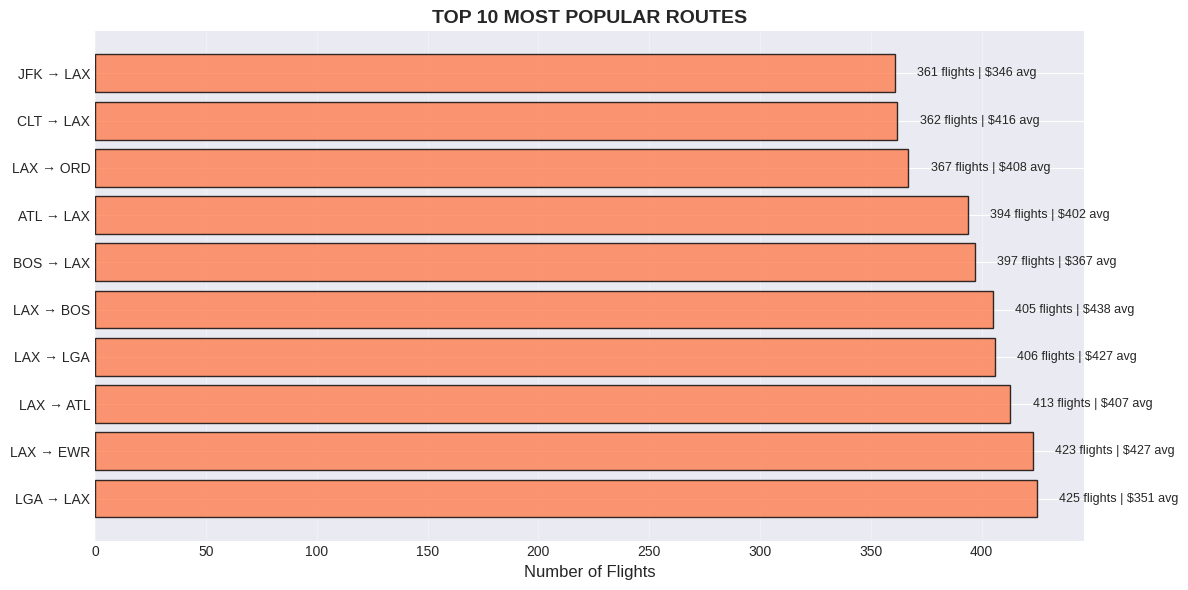

Busiest route: LGA → LAX with 425 flights


In [52]:
# PLOT 8: TOP 10 ROUTES ANALYSIS (SIMPLE)
# =========================================

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Create figure
plt.figure(figsize=(12, 6))

# Calculate route statistics
route_stats = df_final.groupby(['startingAirport', 'destinationAirport']).agg({
    'legId': 'count',
    'totalFare': 'mean'
}).reset_index()
route_stats.columns = ['origin', 'destination', 'count', 'avg_fare']

# Create route name
route_stats['route'] = route_stats['origin'] + ' → ' + route_stats['destination']

# Get top 10 routes by volume
top_routes = route_stats.nlargest(10, 'count')

# Create horizontal bar chart
y_pos = np.arange(len(top_routes))
bars = plt.barh(y_pos, top_routes['count'], color='coral', alpha=0.8, edgecolor='black')

# Set labels
plt.yticks(y_pos, top_routes['route'], fontsize=10)
plt.xlabel('Number of Flights', fontsize=12)
plt.title('TOP 10 MOST POPULAR ROUTES', fontsize=14, fontweight='bold')

# Add count labels on bars
for i, (bar, count, fare) in enumerate(zip(bars, top_routes['count'], top_routes['avg_fare'])):
    plt.text(bar.get_width() + 10, bar.get_y() + bar.get_height()/2,
             f'{count:,} flights | ${fare:.0f} avg',
             ha='left', va='center', fontsize=9)

# Add grid
plt.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

print(f"Busiest route: {top_routes.iloc[0]['route']} with {top_routes.iloc[0]['count']:,} flights")

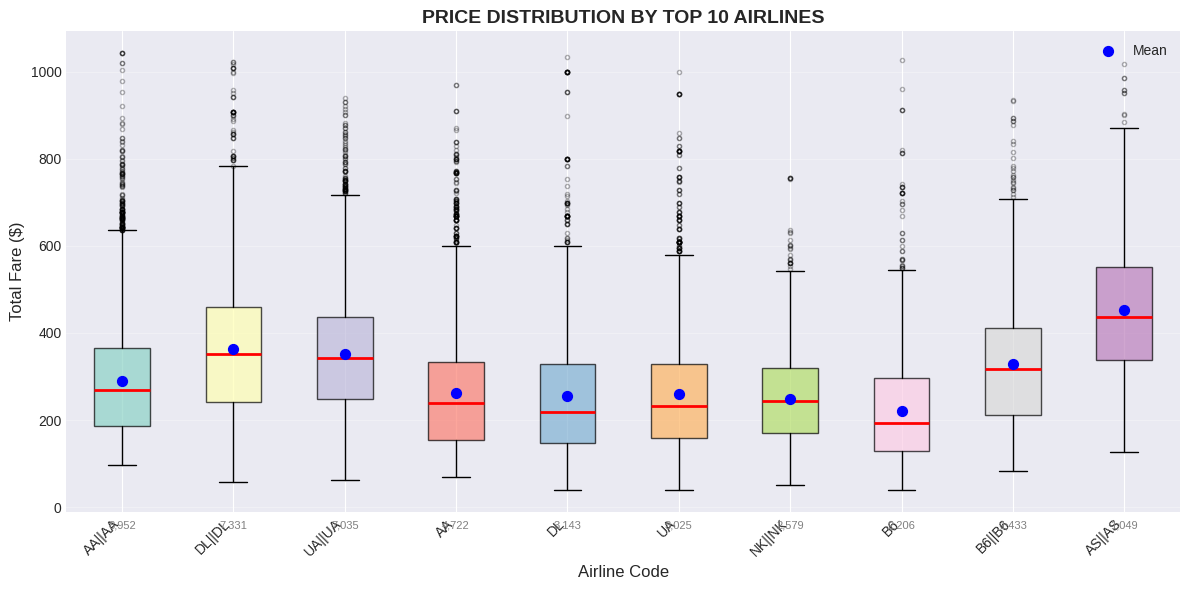

Airlines shown: AA||AA, DL||DL, UA||UA, AA, DL and 5 others


In [53]:
# PLOT 9: PRICE DISTRIBUTION BY AIRLINE (SIMPLE)
# ===============================================

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Create figure
plt.figure(figsize=(12, 6))

# Get top 10 airlines by volume
airline_counts = df_final['segmentsAirlineCode'].value_counts().head(10)
top_airlines = airline_counts.index.tolist()

# Filter data for top airlines
df_airlines = df_final[df_final['segmentsAirlineCode'].isin(top_airlines)]

# Create box plot
box_plot = plt.boxplot([df_airlines[df_airlines['segmentsAirlineCode'] == airline]['totalFare'].values
                        for airline in top_airlines],
                       labels=top_airlines,
                       patch_artist=True,
                       medianprops=dict(color='red', linewidth=2),
                       flierprops=dict(marker='o', markersize=3, alpha=0.3))

# Color the boxes
colors = plt.cm.Set3(range(len(top_airlines)))
for patch, color in zip(box_plot['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

# Labels and title
plt.xlabel('Airline Code', fontsize=12)
plt.ylabel('Total Fare ($)', fontsize=12)
plt.title('PRICE DISTRIBUTION BY TOP 10 AIRLINES', fontsize=14, fontweight='bold')

# Rotate x labels
plt.xticks(rotation=45, ha='right')

# Add mean values
means = [df_airlines[df_airlines['segmentsAirlineCode'] == airline]['totalFare'].mean()
         for airline in top_airlines]
plt.scatter(range(1, len(top_airlines) + 1), means,
           color='blue', s=50, zorder=5, label='Mean')

# Add flight counts below
for i, (airline, count) in enumerate(zip(top_airlines, airline_counts), 1):
    plt.text(i, plt.ylim()[0] - 20, f'{count:,}',
            ha='center', va='top', fontsize=8, color='gray')

# Legend
plt.legend()

# Grid
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"Airlines shown: {', '.join(top_airlines[:5])} and {len(top_airlines)-5} others")

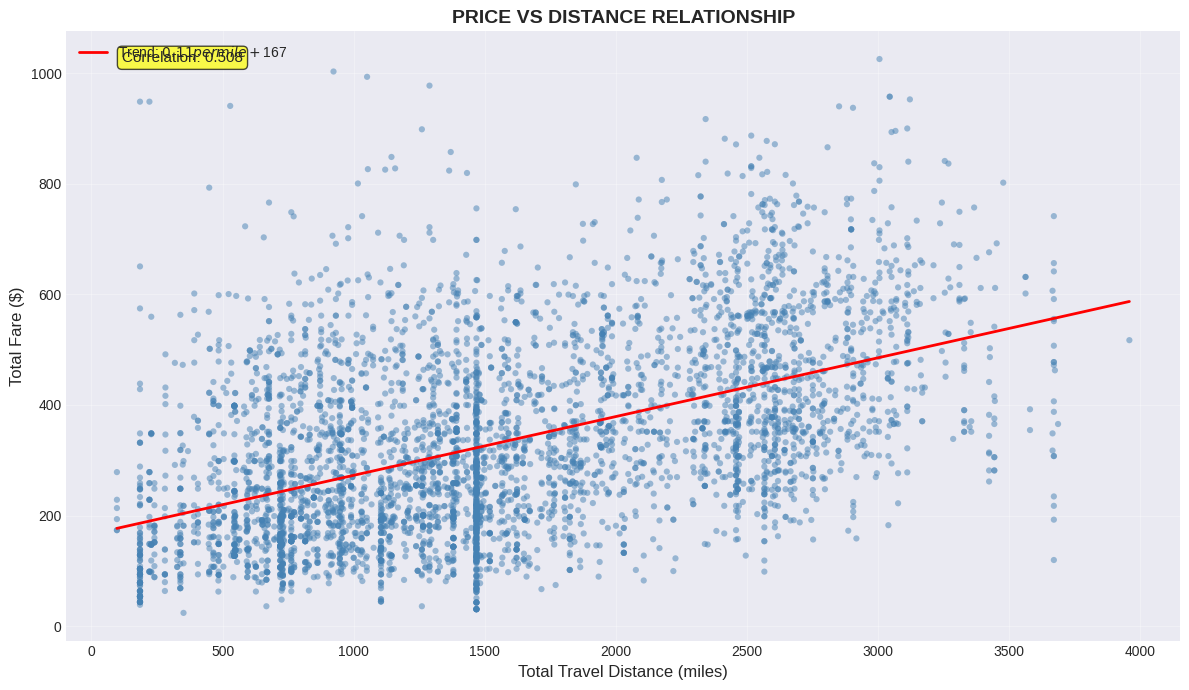

Analysis based on 5,000 flights
Correlation coefficient: 0.508
Price increases approximately $0.11 per mile


In [58]:
# PLOT 11: DISTANCE VS PRICE RELATIONSHIP (SIMPLE)
# =================================================

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import builtins # Import builtins to explicitly use the built-in min function

# Create figure
plt.figure(figsize=(12, 7))

# Sample data for better performance (max 5000 points)
sample_size = builtins.min(5000, len(df_final)) # Use builtins.min
df_sample = df_final.sample(n=sample_size, random_state=42)

# Create scatter plot
plt.scatter(df_sample['totalTravelDistance'], df_sample['totalFare'],
            alpha=0.5, s=20, c='steelblue', edgecolors='none')

# Add trend line
x = df_sample['totalTravelDistance'].dropna()
y = df_sample.loc[x.index, 'totalFare']

# Fit linear regression
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
x_line = np.linspace(x.min(), x.max(), 100)
plt.plot(x_line, p(x_line), 'r-', linewidth=2,
         label=f'Trend: ${z[0]:.2f} per mile + ${z[1]:.0f}')

# Labels and title
plt.xlabel('Total Travel Distance (miles)', fontsize=12)
plt.ylabel('Total Fare ($)', fontsize=12)
plt.title('PRICE VS DISTANCE RELATIONSHIP', fontsize=14, fontweight='bold')

# Add correlation
correlation = df_sample['totalTravelDistance'].corr(df_sample['totalFare'])
plt.text(0.05, 0.95, f'Correlation: {correlation:.3f}',
         transform=plt.gca().transAxes, fontsize=11,
         bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))

# Legend and grid
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Analysis based on {sample_size:,} flights")
print(f"Correlation coefficient: {correlation:.3f}")
print(f"Price increases approximately ${z[0]:.2f} per mile")

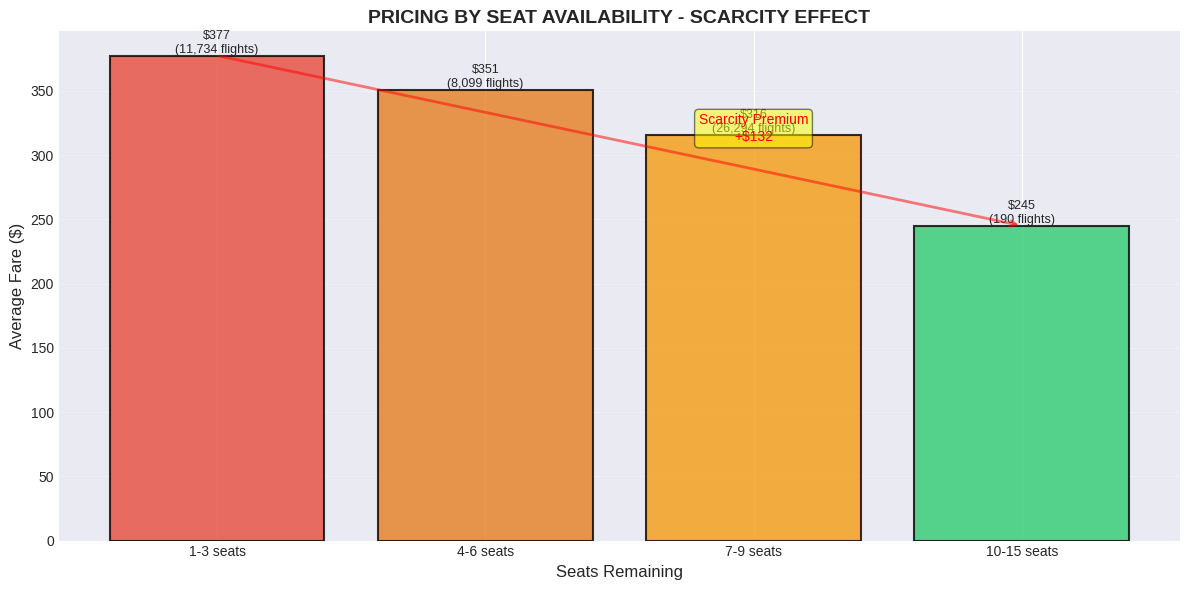

Price difference (few vs many seats): $132
Scarcity premium when only 1-3 seats left: 54.1%


In [59]:
# PLOT 12: SEAT AVAILABILITY IMPACT ON PRICE (SIMPLE)
# ====================================================

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Create figure
plt.figure(figsize=(12, 6))

# Create seat availability categories
df_final['seat_category'] = pd.cut(df_final['seatsRemaining'],
                                    bins=[0, 3, 6, 9, 15, 100],
                                    labels=['1-3 seats', '4-6 seats', '7-9 seats',
                                           '10-15 seats', '15+ seats'])

# Calculate average price for each category
seat_price = df_final.groupby('seat_category', observed=True).agg({
    'totalFare': 'mean',
    'legId': 'count'
}).reset_index()
seat_price.columns = ['category', 'avg_fare', 'count']

# Create bar plot
bars = plt.bar(range(len(seat_price)), seat_price['avg_fare'],
               color=['#e74c3c', '#e67e22', '#f39c12', '#2ecc71', '#27ae60'],
               alpha=0.8, edgecolor='black', linewidth=1.5)

# Set x-axis labels
plt.xticks(range(len(seat_price)), seat_price['category'])
plt.xlabel('Seats Remaining', fontsize=12)
plt.ylabel('Average Fare ($)', fontsize=12)
plt.title('PRICING BY SEAT AVAILABILITY - SCARCITY EFFECT', fontsize=14, fontweight='bold')

# Add value labels on bars
for i, (bar, fare, count) in enumerate(zip(bars, seat_price['avg_fare'], seat_price['count'])):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height,
             f'${fare:.0f}\n({count:,} flights)',
             ha='center', va='bottom', fontsize=9)

# Add trend arrow
if len(seat_price) > 1:
    price_change = seat_price['avg_fare'].iloc[0] - seat_price['avg_fare'].iloc[-1]
    if price_change > 0:
        plt.annotate('', xy=(len(seat_price)-1, seat_price['avg_fare'].iloc[-1]),
                    xytext=(0, seat_price['avg_fare'].iloc[0]),
                    arrowprops=dict(arrowstyle='->', color='red', lw=2, alpha=0.5))
        plt.text(len(seat_price)/2, np.mean([seat_price['avg_fare'].min(), seat_price['avg_fare'].max()]),
                f'Scarcity Premium\n+${price_change:.0f}',
                ha='center', fontsize=10, color='red',
                bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5))

# Grid
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"Price difference (few vs many seats): ${seat_price['avg_fare'].iloc[0] - seat_price['avg_fare'].iloc[-1]:.0f}")
print(f"Scarcity premium when only 1-3 seats left: {(seat_price['avg_fare'].iloc[0] / seat_price['avg_fare'].iloc[-1] - 1) * 100:.1f}%")

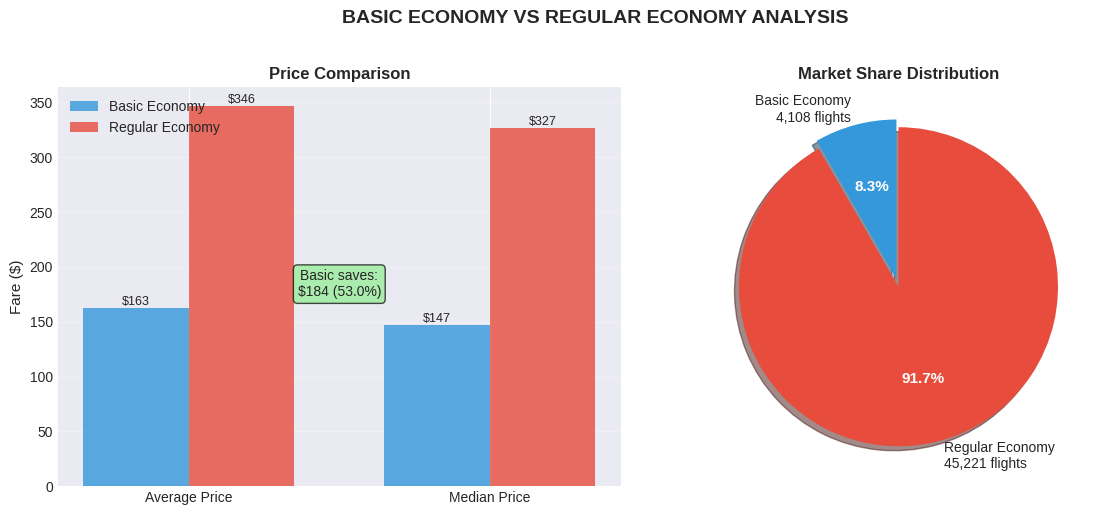


Summary:
Basic Economy: 4,108 flights (8.3%)
Regular Economy: 45,221 flights (91.7%)
Average savings with Basic Economy: $184 (53.0%)


In [60]:
# PLOT 13: BASIC VS REGULAR ECONOMY ANALYSIS (SIMPLE)
# ====================================================

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Create figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Separate data
basic_economy = df_final[df_final['isBasicEconomy'] == True]
regular_economy = df_final[df_final['isBasicEconomy'] == False]

# SUBPLOT 1: Price Comparison
ax1 = axes[0]

# Calculate statistics
basic_stats = {
    'mean': float(basic_economy['totalFare'].mean()),
    'median': float(basic_economy['totalFare'].median()),
    'count': len(basic_economy)
}

regular_stats = {
    'mean': float(regular_economy['totalFare'].mean()),
    'median': float(regular_economy['totalFare'].median()),
    'count': len(regular_economy)
}

# Create grouped bar chart
x = np.arange(2)
width = 0.35

bars1 = ax1.bar(x - width/2, [basic_stats['mean'], basic_stats['median']],
                width, label='Basic Economy', color='#3498db', alpha=0.8)
bars2 = ax1.bar(x + width/2, [regular_stats['mean'], regular_stats['median']],
                width, label='Regular Economy', color='#e74c3c', alpha=0.8)

# Labels
ax1.set_ylabel('Fare ($)', fontsize=11)
ax1.set_title('Price Comparison', fontsize=12, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(['Average Price', 'Median Price'])
ax1.legend()

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2, height,
                f'${height:.0f}', ha='center', va='bottom', fontsize=9)

# Add savings indicator
savings = regular_stats['mean'] - basic_stats['mean']
ax1.text(0.5, np.max([basic_stats['mean'], regular_stats['mean']]) * 0.5,
         f'Basic saves:\n${savings:.0f} ({savings/regular_stats["mean"]*100:.1f}%)',
         ha='center', fontsize=10,
         bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7))

# SUBPLOT 2: Market Share Pie Chart
ax2 = axes[1]

sizes = [basic_stats['count'], regular_stats['count']]
labels = [f'Basic Economy\n{basic_stats["count"]:,} flights',
          f'Regular Economy\n{regular_stats["count"]:,} flights']
colors = ['#3498db', '#e74c3c']
explode = (0.05, 0)  # Slightly separate basic economy

wedges, texts, autotexts = ax2.pie(sizes, labels=labels, colors=colors,
                                    explode=explode, autopct='%1.1f%%',
                                    shadow=True, startangle=90)

# Make percentage text bold
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(11)

ax2.set_title('Market Share Distribution', fontsize=12, fontweight='bold')

# Overall title
fig.suptitle('BASIC ECONOMY VS REGULAR ECONOMY ANALYSIS',
             fontsize=14, fontweight='bold', y=1.02)

# Add grid to bar chart
ax1.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Print summary
print("\nSummary:")
print(f"Basic Economy: {basic_stats['count']:,} flights ({basic_stats['count']/(basic_stats['count']+regular_stats['count'])*100:.1f}%)")
print(f"Regular Economy: {regular_stats['count']:,} flights ({regular_stats['count']/(basic_stats['count']+regular_stats['count'])*100:.1f}%)")
print(f"Average savings with Basic Economy: ${savings:.0f} ({savings/regular_stats['mean']*100:.1f}%)")

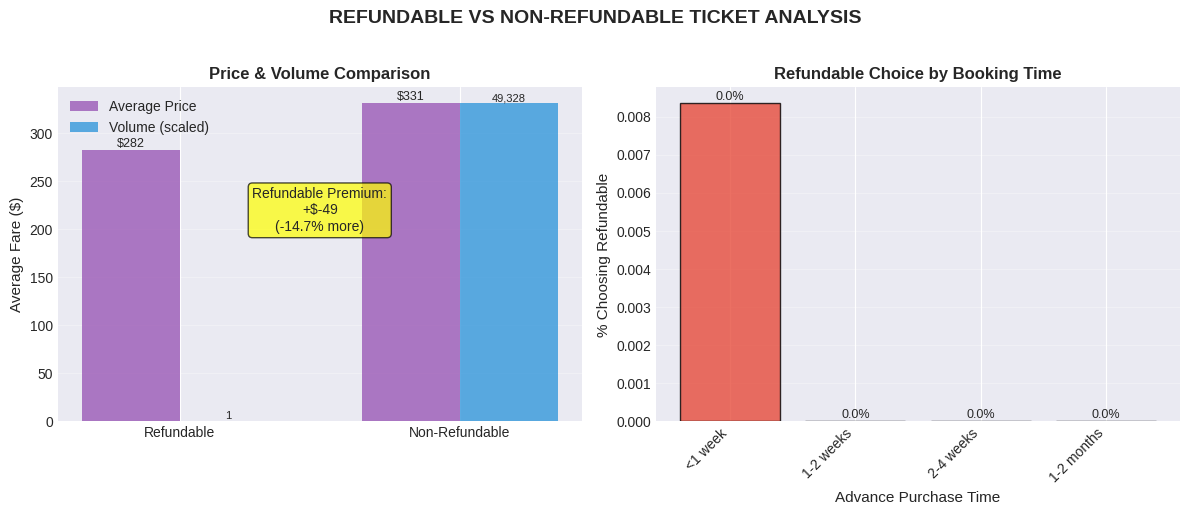


Summary:
Refundable tickets: 1 (0.0%)
Non-refundable tickets: 49,328 (100.0%)
Refundable premium: $-49 (-14.7%)


In [62]:
# PLOT 14: REFUNDABLE VS NON-REFUNDABLE ANALYSIS (SIMPLE)
# ========================================================

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Create advance_purchase_days if it doesn't exist
if 'advance_purchase_days' not in df_final.columns:
    df_final['searchDate'] = pd.to_datetime(df_final['searchDate'])
    df_final['flightDate'] = pd.to_datetime(df_final['flightDate'])
    df_final['advance_purchase_days'] = (df_final['flightDate'] - df_final['searchDate']).dt.days

# Create figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Separate data
refundable = df_final[df_final['isRefundable'] == True]
non_refundable = df_final[df_final['isRefundable'] == False]

# Calculate statistics
categories = ['Refundable', 'Non-Refundable']
avg_prices = [float(refundable['totalFare'].mean()),
              float(non_refundable['totalFare'].mean())]
counts = [len(refundable), len(non_refundable)]

# SUBPLOT 1: Price and Volume Comparison
x = np.arange(len(categories))
width = 0.35

# Normalize counts for dual axis
max_count = np.max(counts)
normalized_counts = [c/max_count * np.max(avg_prices) for c in counts]

bars1 = ax1.bar(x - width/2, avg_prices, width,
                label='Average Price', color='#9b59b6', alpha=0.8)
bars2 = ax1.bar(x + width/2, normalized_counts, width,
                label=f'Volume (scaled)', color='#3498db', alpha=0.8)

ax1.set_ylabel('Average Fare ($)', fontsize=11)
ax1.set_title('Price & Volume Comparison', fontsize=12, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(categories)
ax1.legend()

# Add actual values
for i, (bar1, bar2, price, count) in enumerate(zip(bars1, bars2, avg_prices, counts)):
    ax1.text(bar1.get_x() + bar1.get_width()/2, bar1.get_height(),
            f'${price:.0f}', ha='center', va='bottom', fontsize=9)
    ax1.text(bar2.get_x() + bar2.get_width()/2, bar2.get_height(),
            f'{count:,}', ha='center', va='bottom', fontsize=8)

# Calculate and show premium
premium = avg_prices[0] - avg_prices[1]
premium_pct = (premium / avg_prices[1]) * 100 if avg_prices[1] > 0 else 0
ax1.text(0.5, np.max(avg_prices) * 0.6,
         f'Refundable Premium:\n+${premium:.0f}\n({premium_pct:.1f}% more)',
         ha='center', fontsize=10,
         bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))

# SUBPLOT 2: Distribution by Advance Purchase
ax2.set_title('Refundable Choice by Booking Time', fontsize=12, fontweight='bold')

# Create advance purchase bins
df_final['advance_bins'] = pd.cut(df_final['advance_purchase_days'],
                                  bins=[0, 7, 14, 30, 60, 365],
                                  labels=['<1 week', '1-2 weeks', '2-4 weeks',
                                         '1-2 months', '>2 months'])

# Calculate refundable percentage for each bin
refund_by_advance = df_final.groupby('advance_bins', observed=True).agg({
    'isRefundable': 'mean'
}).reset_index()
refund_by_advance['refund_pct'] = refund_by_advance['isRefundable'] * 100

# Only plot if we have data
if len(refund_by_advance) > 0:
    bars3 = ax2.bar(range(len(refund_by_advance)), refund_by_advance['refund_pct'],
                    color=['#e74c3c', '#e67e22', '#f39c12', '#2ecc71', '#27ae60'][:len(refund_by_advance)],
                    alpha=0.8, edgecolor='black')

    ax2.set_xticks(range(len(refund_by_advance)))
    ax2.set_xticklabels(refund_by_advance['advance_bins'], rotation=45, ha='right')
    ax2.set_ylabel('% Choosing Refundable', fontsize=11)
    ax2.set_xlabel('Advance Purchase Time', fontsize=11)

    # Add percentage labels
    for bar, pct in zip(bars3, refund_by_advance['refund_pct']):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
                f'{pct:.1f}%', ha='center', va='bottom', fontsize=9)
else:
    ax2.text(0.5, 0.5, 'No advance purchase data available',
             ha='center', va='center', fontsize=12)

# Add grid
ax1.grid(True, alpha=0.3, axis='y')
ax2.grid(True, alpha=0.3, axis='y')

# Overall title
fig.suptitle('REFUNDABLE VS NON-REFUNDABLE TICKET ANALYSIS',
             fontsize=14, fontweight='bold', y=1.02)

plt.tight_layout()
plt.show()

# Print summary
total = counts[0] + counts[1]
print("\nSummary:")
print(f"Refundable tickets: {counts[0]:,} ({counts[0]/total*100:.1f}%)")
print(f"Non-refundable tickets: {counts[1]:,} ({counts[1]/total*100:.1f}%)")
print(f"Refundable premium: ${premium:.0f} ({premium_pct:.1f}%)")

TypeError: min() takes 1 positional argument but 2 were given

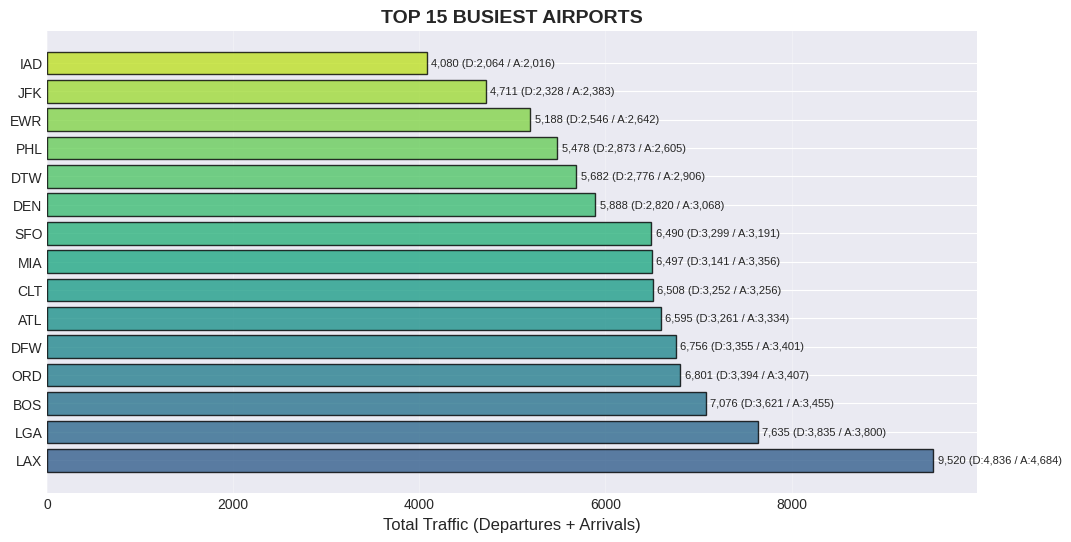

In [65]:
# PLOT 15: TOP AIRPORTS BY TRAFFIC VOLUME (SIMPLE)
# =================================================

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Create figure
plt.figure(figsize=(12, 6))

# Calculate total traffic for each airport (departures + arrivals)
departures = df_final['startingAirport'].value_counts()
arrivals = df_final['destinationAirport'].value_counts()

# Combine departures and arrivals
total_traffic = pd.concat([departures, arrivals]).groupby(level=0).sum().sort_values(ascending=False)

# Get top 15 airports
top_airports = total_traffic.head(15)

# Create horizontal bar chart
colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(top_airports)))
bars = plt.barh(range(len(top_airports)), top_airports.values,
                color=colors, alpha=0.8, edgecolor='black', linewidth=1)

# Set labels
plt.yticks(range(len(top_airports)), top_airports.index)
plt.xlabel('Total Traffic (Departures + Arrivals)', fontsize=12)
plt.title('TOP 15 BUSIEST AIRPORTS', fontsize=14, fontweight='bold')

# Add value labels on bars
for i, (bar, value) in enumerate(zip(bars, top_airports.values)):
    # Get departure and arrival counts separately
    dep_count = departures.get(top_airports.index[i], 0)
    arr_count = arrivals.get(top_airports.index[i], 0)
    plt.text(bar.get_width() + 50, bar.get_y() + bar.get_height()/2,
             f'{value:,} (D:{dep_count:,} / A:{arr_count:,})',
             ha='left', va='center', fontsize=8)

# Add grid
plt.grid(True, alpha=0.3, axis='x')

# Highlight top 3
for i in range(min(3, len(bars))):
    bars[i].set_edgecolor('red')
    bars[i].set_linewidth(2.5)

# Add legend for highlighting
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='gray', edgecolor='red', linewidth=2.5, label='Top 3 Airports')]
plt.legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.show()

# Print summary
print("\nTop 5 Busiest Airports:")
for i, (airport, count) in enumerate(top_airports.head(5).items(), 1):
    dep = departures.get(airport, 0)
    arr = arrivals.get(airport, 0)
    print(f"{i}. {airport}: {count:,} total ({dep:,} departures, {arr:,} arrivals)")

In [68]:
print("\n1️⃣ IDENTIFYING COLUMN TYPES")
print("-"*40)

# Numeric columns that need scaling
numeric_columns = [
    'travelDuration',
    'elapsedDays',
    'baseFare',
    'totalFare',
    'seatsRemaining',
    'totalTravelDistance',
    'segmentsDepartureTimeEpochSeconds',
    'segmentsArrivalTimeEpochSeconds',
    'segmentsDurationInSeconds',
    'segmentsDistance'
]

# Binary columns (already 0/1, no scaling needed)
binary_columns = [
    'isBasicEconomy',
    'isRefundable',
    'isNonStop'
]

# Categorical columns that need encoding
categorical_columns = [
    'startingAirport',
    'destinationAirport',
    'fareBasisCode',
    'segmentsArrivalAirportCode',
    'segmentsDepartureAirportCode',
    'segmentsAirlineName',
    'segmentsAirlineCode',
    'segmentsEquipmentDescription',
    'segmentsCabinCode'
]

# Date columns
date_columns = ['searchDate', 'flightDate']

print(f"Numeric columns to scale: {len(numeric_columns)}")
print(f"Binary columns: {len(binary_columns)}")
print(f"Categorical columns: {len(categorical_columns)}")
print(f"Date columns: {len(date_columns)}")


1️⃣ IDENTIFYING COLUMN TYPES
----------------------------------------
Numeric columns to scale: 10
Binary columns: 3
Categorical columns: 9
Date columns: 2


In [69]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

In [72]:
df_universal = df_final.copy()

# Identify numeric columns to scale
numeric_cols = df_final.select_dtypes(include=[np.number]).columns.tolist()

# Remove ID columns and binary flags from scaling
cols_not_to_scale = ['legId', 'isBasicEconomy', 'isRefundable', 'isNonStop']
numeric_cols = [col for col in numeric_cols if col not in cols_not_to_scale]


In [73]:
scaler = StandardScaler()
df_universal[numeric_cols] = scaler.fit_transform(df_universal[numeric_cols])

In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')

In [75]:
feature_columns = [
    'travelDuration',
    'elapsedDays',
    'isBasicEconomy',
    'isRefundable',
    'isNonStop',
    'baseFare',
    'seatsRemaining',
    'totalTravelDistance',
    'segmentsDurationInSeconds'
]

target_column = 'totalFare'


In [77]:
available_features = [col for col in feature_columns if col in df_final.columns]
X = df_final[available_features].values
y = df_final[target_column].values


In [81]:
scaler_X = MinMaxScaler()

# Define the original list of potential feature columns
original_feature_columns = [
    'travelDuration', # This will be replaced by travelDuration_minutes if available
    'elapsedDays',
    'isBasicEconomy',
    'isRefundable',
    'isNonStop',
    'baseFare',
    'totalFare', # Keep totalFare in the original list, but it's the target
    'seatsRemaining',
    'totalTravelDistance',
    # Exclude multi-segment string columns and the original travelDuration string column
]

# Filter out multi-segment string columns and the original travelDuration string column
features_to_consider = [
    col for col in original_feature_columns
    if col not in [
        'travelDuration',
        'segmentsDepartureTimeEpochSeconds',
        'segmentsArrivalTimeEpochSeconds',
        'segmentsDurationInSeconds',
        'segmentsDistance'
    ]
]

# Add travelDuration_minutes if it exists in df_final and replace travelDuration if it was in the original list
if 'travelDuration_minutes' in df_final.columns and 'travelDuration' in original_feature_columns:
     # Find the index of 'travelDuration' and replace it
     try:
         idx = features_to_consider.index('travelDuration') # This will raise ValueError if not found
         features_to_consider[idx] = 'travelDuration_minutes'
     except ValueError:
         # If 'travelDuration' wasn't in the original list but travelDuration_minutes exists, add it
         if 'travelDuration_minutes' not in features_to_consider:
              features_to_consider.append('travelDuration_minutes')
elif 'travelDuration' in features_to_consider:
    # If travelDuration_minutes doesn't exist but travelDuration is in features_to_consider, remove travelDuration
    features_to_consider.remove('travelDuration')


# Ensure all selected features exist in df_final
available_features = [col for col in features_to_consider if col in df_final.columns]

# Separate numerical and binary/boolean features
numerical_features = df_final[available_features].select_dtypes(include=np.number).columns.tolist()
boolean_features = df_final[available_features].select_dtypes(include='bool').columns.tolist()

# Remove the target column from numerical features if it's there
if target_column in numerical_features:
    numerical_features.remove(target_column)

# Check if there are any features left to scale
if not numerical_features and not boolean_features:
    print("Error: No valid numerical or boolean features available for processing.")
else:
    # Scale numerical features
    if numerical_features:
        X_numerical = df_final[numerical_features].values
        X_numerical_scaled = scaler_X.fit_transform(X_numerical)
        X_numerical_scaled_df = pd.DataFrame(X_numerical_scaled, columns=numerical_features, index=df_final.index)
    else:
        X_numerical_scaled_df = pd.DataFrame(index=df_final.index) # Empty DataFrame with correct index

    # Keep boolean features as they are (they are already 0 or 1)
    if boolean_features:
        X_boolean_df = df_final[boolean_features].astype(int) # Convert bool to int (0/1)
    else:
        X_boolean_df = pd.DataFrame(index=df_final.index) # Empty DataFrame with correct index


    # Combine scaled numerical features and boolean features
    # Use align to handle potentially different indices if NaNs were dropped differently
    X_combined = X_numerical_scaled_df.join(X_boolean_df, how='inner') # Use inner join to ensure index alignment
    X = X_combined.values # Get the combined numpy array for the model

    # Scale the target variable
    y = df_final[target_column].values
    scaler_y = MinMaxScaler()
    y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

    print(f"Scaled: X[{X.min():.2f}, {X.max():.2f}], y[{y_scaled.min():.2f}, {y_scaled.max():.2f}]")
    print(f"Number of features used: {X.shape[1]}")

Scaled: X[0.00, 1.00], y[0.00, 1.00]
Number of features used: 8


In [82]:
def create_sequences(X, y, seq_length=5):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i+seq_length])
        y_seq.append(y[i+seq_length])
    return np.array(X_seq), np.array(y_seq)

SEQ_LENGTH = 5
X_seq, y_seq = create_sequences(X, y_scaled, SEQ_LENGTH)
print(f"Sequences created: {X_seq.shape}")

Sequences created: (49324, 5, 8)


In [83]:
X_train, X_test, y_train, y_test = train_test_split(
    X_seq, y_seq, test_size=0.2, random_state=42, shuffle=True
)

print(f"Train: {X_train.shape}, Test: {X_test.shape}")

Train: (39459, 5, 8), Test: (9865, 5, 8)


In [86]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings

In [87]:
scaler_X = MinMaxScaler()

original_feature_columns = [
    'travelDuration',
    'elapsedDays',
    'isBasicEconomy',
    'isRefundable',
    'isNonStop',
    'baseFare',
    'totalFare',
    'seatsRemaining',
    'totalTravelDistance',
]

features_to_consider = [
    col for col in original_feature_columns
    if col not in [
        'travelDuration',
        'segmentsDepartureTimeEpochSeconds',
        'segmentsArrivalTimeEpochSeconds',
        'segmentsDurationInSeconds',
        'segmentsDistance'
    ]
]

if 'travelDuration_minutes' in df_final.columns and 'travelDuration' in original_feature_columns:
    try:
        idx = features_to_consider.index('travelDuration')
        features_to_consider[idx] = 'travelDuration_minutes'
    except ValueError:
        if 'travelDuration_minutes' not in features_to_consider:
            features_to_consider.append('travelDuration_minutes')
elif 'travelDuration' in features_to_consider:
    features_to_consider.remove('travelDuration')

available_features = [col for col in features_to_consider if col in df_final.columns]

numerical_features = df_final[available_features].select_dtypes(include=np.number).columns.tolist()
boolean_features = df_final[available_features].select_dtypes(include='bool').columns.tolist()

target_column = 'totalFare'
if target_column in numerical_features:
    numerical_features.remove(target_column)

if numerical_features:
    X_numerical = df_final[numerical_features].values
    X_numerical_scaled = scaler_X.fit_transform(X_numerical)
    X_numerical_scaled_df = pd.DataFrame(X_numerical_scaled, columns=numerical_features, index=df_final.index)
else:
    X_numerical_scaled_df = pd.DataFrame(index=df_final.index)

if boolean_features:
    X_boolean_df = df_final[boolean_features].astype(int)
else:
    X_boolean_df = pd.DataFrame(index=df_final.index)

X_combined = X_numerical_scaled_df.join(X_boolean_df, how='inner')
X = X_combined.values

y = df_final[target_column].values
scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

print(f"Features: {X.shape[1]}")
print(f"Samples: {X.shape[0]}")

# ================================

# CELL 3: Create LSTM Sequences
def create_sequences(X, y, seq_length=5):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i+seq_length])
        y_seq.append(y[i+seq_length])
    return np.array(X_seq), np.array(y_seq)

SEQ_LENGTH = 5
X_seq, y_seq = create_sequences(X, y_scaled, SEQ_LENGTH)
print(f"Sequences created: {X_seq.shape}")

# ================================

# CELL 4: Train Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_seq, y_seq, test_size=0.2, random_state=42, shuffle=True
)

print(f"Train: {X_train.shape}, Test: {X_test.shape}")

# ================================

# CELL 5: Build Optimized LSTM Model
n_features = X_train.shape[2]

model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(SEQ_LENGTH, n_features)),
    Dropout(0.2),
    BatchNormalization(),

    LSTM(50, return_sequences=False),
    Dropout(0.2),
    BatchNormalization(),

    Dense(25, activation='relu'),
    Dropout(0.1),

    Dense(1)
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae', 'mse']
)

print(model.summary())

# ================================

# CELL 6: Train LSTM
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=1e-6)

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.15,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# ================================



Features: 8
Samples: 49329
Sequences created: (49324, 5, 8)
Train: (39459, 5, 8), Test: (9865, 5, 8)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 5, 100)         │        43,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 5, 100)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 5, 100)         │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 50)             │           200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 25)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,701 (295.71 KB)

 Trainable params: 75,401 (294.54 KB)

 Non-trainable params: 300 (1.17 KB)

None
Epoch 1/50
1049/1049 ━━━━━━━━━━━━━━━━━━━━ 16s 12ms/step - loss: 0.1647 - mae: 0.2840 - mse: 0.1647 - val_loss: 0.0228 - val_mae: 0.1165 - val_mse: 0.0228 - learning_rate: 0.0010
Epoch 2/50
1049/1049 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - loss: 0.0251 - mae: 0.1241 - mse: 0.0251 - val_loss: 0.0210 - val_mae: 0.1130 - val_mse: 0.0210 - learning_rate: 0.0010
Epoch 3/50
1049/1049 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - loss: 0.0219 - mae: 0.1154 - mse: 0.0219 - val_loss: 0.0198 - val_mae: 0.1090 - val_mse: 0.0198 - learning_rate: 0.0010
Epoch 4/50
1049/1049 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - loss: 0.0203 - mae: 0.1095 - mse: 0.0203 - val_loss: 0.0186 - val_mae: 0.1014 - val_mse: 0.0186 - learning_rate: 0.0010
Epoch 5/50
1049/1049 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - loss: 0.0192 - mae: 0.1044 - mse: 0.0192 - val_loss: 0.0179 - val_mae: 0.0972 - val_mse: 0.0179 - learning_rate: 0.0010
Epoch 6/50
1049/1049 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - loss: 0.0188 - mae: 0.1019 - mse: 0.0188 - val_

In [89]:
y_pred_scaled = model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_original = scaler_y.inverse_transform(y_test)

print(f"Predictions shape: {y_pred.shape}")
print(f"Test set size: {len(y_test_original)}")

309/309 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
Predictions shape: (9865, 1)
Test set size: 9865


In [90]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

mae = mean_absolute_error(y_test_original, y_pred)
mse = mean_squared_error(y_test_original, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_original, y_pred)
mape = mean_absolute_percentage_error(y_test_original, y_pred) * 100

print("="*50)
print("MODEL PERFORMANCE METRICS:")
print("="*50)
print(f"MAE:  ${mae:.2f}")
print(f"RMSE: ${rmse:.2f}")
print(f"R2 Score: {r2:.4f}")
print(f"MAPE: {mape:.2f}%")
print(f"Average actual price: ${y_test_original.mean():.2f}")
print(f"Average predicted price: ${y_pred.mean():.2f}")

MODEL PERFORMANCE METRICS:
MAE:  $93.05
RMSE: $133.13
R2 Score: 0.3858
MAPE: 41.78%
Average actual price: $330.98
Average predicted price: $327.70


In [91]:
print("\n" + "="*50)
print("SAMPLE PREDICTIONS (First 20):")
print("="*50)

predictions_df = pd.DataFrame({
    'Actual': y_test_original.flatten()[:20],
    'Predicted': y_pred.flatten()[:20],
    'Error': (y_test_original.flatten() - y_pred.flatten())[:20],
    'Error%': ((y_test_original.flatten() - y_pred.flatten()) / y_test_original.flatten() * 100)[:20]
})

predictions_df['Actual'] = predictions_df['Actual'].round(2)
predictions_df['Predicted'] = predictions_df['Predicted'].round(2)
predictions_df['Error'] = predictions_df['Error'].round(2)
predictions_df['Error%'] = predictions_df['Error%'].round(1)

print(predictions_df.to_string())


SAMPLE PREDICTIONS (First 20):
    Actual   Predicted   Error  Error%
0   218.60  131.119995   87.48    40.0
1   301.60  314.450012  -12.85    -4.3
2   312.60  503.109985 -190.51   -60.9
3   398.71  361.250000   37.46     9.4
4   433.20  434.489990   -1.29    -0.3
5   481.71  367.510010  114.20    23.7
6   443.60  355.779999   87.82    19.8
7    88.60  284.739990 -196.14  -221.4
8   321.60  339.489990  -17.89    -5.6
9   207.60  244.679993  -37.08   -17.9
10  302.60  269.679993   32.92    10.9
11  115.60  136.199997  -20.60   -17.8
12  597.20  455.700012  141.50    23.7
13  199.99  246.949997  -46.96   -23.5
14  168.61  174.520004   -5.91    -3.5
15  288.60  308.109985  -19.51    -6.8
16  106.10  435.380005 -329.28  -310.4
17  591.61  418.970001  172.64    29.2
18  279.20  338.839996  -59.64   -21.4
19  520.61  156.210007  364.40    70.0


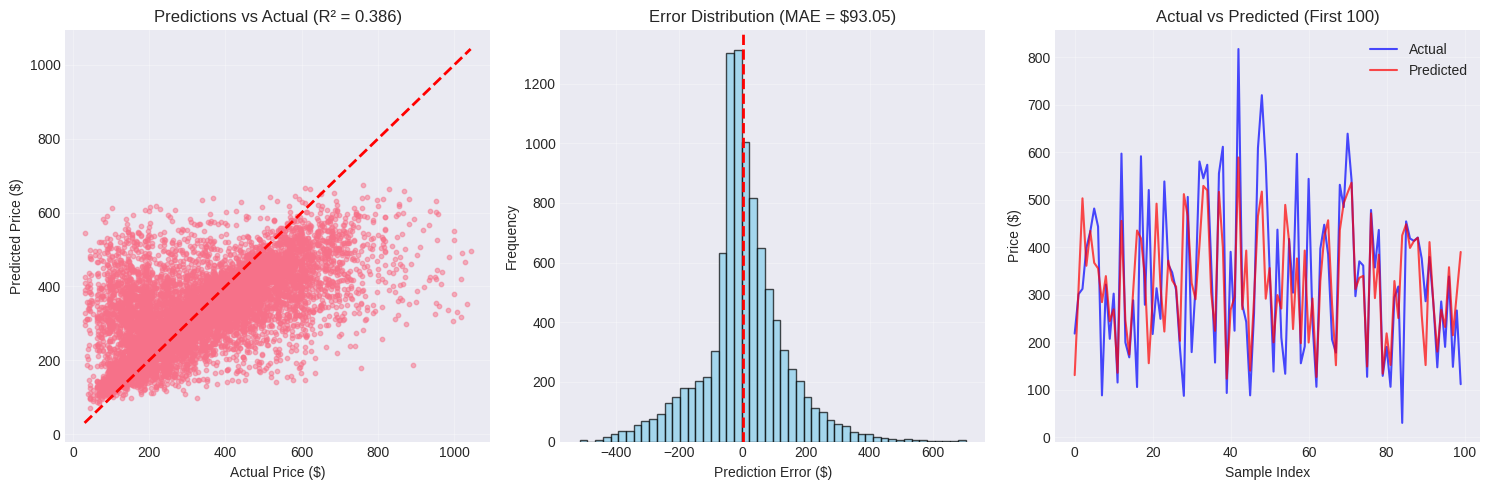

In [94]:
import matplotlib.pyplot as plt
import builtins # Import builtins to explicitly use the built-in min function

plt.figure(figsize=(15, 5))

# Scatter plot
plt.subplot(1, 3, 1)
plt.scatter(y_test_original, y_pred, alpha=0.5, s=10)
plt.plot([y_test_original.min(), y_test_original.max()],
         [y_test_original.min(), y_test_original.max()],
         'r--', lw=2)
plt.xlabel('Actual Price ($)')
plt.ylabel('Predicted Price ($)')
plt.title(f'Predictions vs Actual (R² = {r2:.3f})')
plt.grid(True, alpha=0.3)

# Error distribution
plt.subplot(1, 3, 2)
errors = y_test_original - y_pred
plt.hist(errors, bins=50, edgecolor='black', alpha=0.7, color='skyblue')
plt.xlabel('Prediction Error ($)')
plt.ylabel('Frequency')
plt.title(f'Error Distribution (MAE = ${mae:.2f})')
plt.axvline(x=0, color='red', linestyle='--', linewidth=2)
plt.grid(True, alpha=0.3)

# Time series plot (first 100 predictions)
plt.subplot(1, 3, 3)
n_display = builtins.min(100, len(y_test_original)) # Use builtins.min
plt.plot(range(n_display), y_test_original[:n_display], 'b-', label='Actual', alpha=0.7)
plt.plot(range(n_display), y_pred[:n_display], 'r-', label='Predicted', alpha=0.7)
plt.xlabel('Sample Index')
plt.ylabel('Price ($)')
plt.title('Actual vs Predicted (First 100)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [95]:
model.save('lstm_flight_price_model.h5')
print("\n✅ Model saved as 'lstm_flight_price_model.h5'")


✅ Model saved as 'lstm_flight_price_model.h5'
